<a href="https://colab.research.google.com/github/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_1_Dataset_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IR spectral analysis of organic and coordination compounds via machine learning and neural networks
By: Koshelev Daniil

Based on some code form: https://github.com/rayguna/IR-Spectra-Analyzer

-Work in progress (last updated:10/06/2023)-

A. MOTIVATION

ИК-спектроскопия является универсальным и точным методом химической идентификации, поскольку каждое соединение обладает уникальными ИК-спектральными характеристиками; однако спектральные характеристики, как правило, неоднозначны. Интерпретация вручную часто отнимает много времени и может привести к непоследовательным, ошибочным результатам. Следовательно, существует потребность в быстрой, точной и воспроизводимой альтернативе ручному переводу.

B. Цель

Целью этой программы является автоматизация процедуры интерпретации ИК-спектра известного соединения путем присвоения его полос поглощения имеющимся в молекуле химическим связям или типам колебаний.

C. План

Для реализации задумки предлагается решить следующие задачи:

1. Исходя из списка веществ NIST получить таблицу, содержащую данные про соединения (CAS, название, брутто-формула, молекулярная масса, элементы в составе, SMILE, SELFIE, InChi обозначения, список имеющихся в структуре связей и функциональных групп.
2. Получить ИК-спектры из списка химических веществ, по CAS ключу.
3. Построить соответствие между спектрами и labels, разобраться с типами и количестом labels, осуществить подбор правильного embending для кодирования label.
4. Обработать спектры, приведя их к единому виду и форме. Провести интерполяцию для получения спектров с единым шагом и желательно в едином диапазоне волновых чисел.
5. Разметить спектры метками 17 классов, визуализировать статистику по выборке, оценить баланс классов.
6. Создать объект torch.Dataset, разбить выборку на test, train, val с учётом дисбаланса.
7. Далее работу перевести в другой блокнот для создания и обучения модели.
8. Разметить датасет на 92 (72) класса.

NOTES
1. Получен список веществ, создана таблица.
2. Скачаны спектры более 14000 соединений.
3. Реализованы функции разметки существующих спектров на 17 классов.
4. Визуализированы списки классов.
5. Релазиованы функции форматирования спектров по одному интервалу.
6. Добавлена функция поиска пиков.
7. Реализована разметка на 92 (72) класса.

Клонирование данных с GitHub. На сайте выложены как исходные списки веществ, так и скачанные спектры соединений, которые были запарсены кодом ниже.

In [1]:
!git clone https://github.com/Lamblador/IR_expert_system.git

Cloning into 'IR_expert_system'...
remote: Enumerating objects: 17300, done.
remote: Counting objects: 100% (2457/2457), done.
remote: Compressing objects: 100% (2293/2293), done.
remote: Total 17300 (delta 190), reused 2409 (delta 160), pack-reused 14843
Receiving objects: 100% (17300/17300), 1.48 GiB | 25.06 MiB/s, done.
Resolving deltas: 100% (550/550), done.
Updating files: 100% (16981/16981), done.


In [2]:
# Установка нужных пакетов
from IPython.core.display import clear_output
!pip install --upgrade jcamp
!pip install cirpy
!pip install peakutils
!pip install datamol
!pip install rdkit
clear_output()

In [3]:
# Вводятся нужные импорты
import pandas as pd
import matplotlib.pyplot as plt
import re  # for string manipulations
import requests
#import peakutils
from bs4 import BeautifulSoup  # for webscraping
import urllib.request
import time
import random
from tqdm import tqdm
import jcamp
from jcamp import jcamp_readfile
import glob
import os
import numpy as np
from urllib.request import urlopen
import logging
import argparse
import sys
import datamol as dm
import scipy
from scipy import interpolate

from rdkit import Chem, RDLogger

#Получение таблицы данных

##Сохранение периодической таблицы химических элементов

In [4]:
#create an ordered dictionary. In this case, order of elements is important.
import collections

# periodic_table['element_name']=['atomic_number','atomic_mass']
periodic_table = collections.OrderedDict()  # initialize dictionary.


def create_periodic_table(file_name):
    """ Read a text file line-by-line and extract information for: atomic number, atomic symbol, and relative atomic mass

        The author is aware of at least one python periodic elements package (e.g., https://pypi.python.org/pypi/periodictable),
        but chose to implement a different approach.
    """

    file = open(file_name, 'r')  # open a file to read

    for line in file:  # read file line-by-line, extract values, and store into a dictionary

        if line.startswith('Atomic Number'):
            line = line.replace(" ", "")
            value1 = line.split('=', 1)

        if line.startswith('Atomic Symbol'):
            line = line.replace(" ", "")
            key = line.split('=', 1)

        if line.startswith('Relative Atomic Mass'):
            line = line.replace(" ", "")
            value2 = line.split('=', 1)

            # Store values into dictionary only if the element is unique.
            # Otherwise, the atomic mass will be override by isotope's atomic
            # mass.
            if key[1].strip() not in list(periodic_table.keys()):
                periodic_table[key[1].strip()] = [
                    value1[1].strip(), value2[1].strip()]
            else:
                pass

    return periodic_table

# End of functions

In [5]:
# 1-1a. Call out function
file_name = '/content/IR_expert_system/data/NIST_periodic_table.txt'
periodic_table = create_periodic_table(file_name)

# 1-1b.Test out dictionary by calling out the element keys
print(list(periodic_table.keys()))
print("\n")
print("Number of dictinct elements in the dictionary:", len(periodic_table))

['H', 'D', 'T', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']


Number of dictinct elements in the dictionary: 120


##Получение таблицы из списка соеинений NIST и расчёт молярной массы.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re  # for string manipulations
import requests
#import peakutils
from bs4 import BeautifulSoup  # for webscraping
#from peakutils.peak import indexes as index_utils  # for peak picking


def read_and_clean_nist_chem_list(no_of_files=72619):
    """ Read and clean a stored csv file called "NIST_chemicals_list.csv"

    Args:
    no_of_files=specifies how many files to read from the list. The max. no. is 72619.

    Returns:
    a NIST chemicals list dataframe.

    """

    # read file
    col_names = ['Name', 'Formula', 'CAS']
    # Rename columns
    df = pd.read_csv("/content/IR_expert_system/data/NIST_chemicals_list.csv", header=1, names=col_names)
    # Remove rows that have null objects and keep only rows with no na values
    df = df.dropna()
    # make CAS the index column
    df = df.set_index('CAS')

    return df


def extract_unique_elements(df):
    """Given a pandas DataFrame containing a column of chemical formula, return the DataFrame
        with an additional column containing unique elements in the formula called df['Elements']

        Args:
        df_Formula=a column of chemical formula in a pandas DataFrame
        Return:
        a list of unique elements
    """

    #1a. check for formulas that contain ')n' and remove it
    ##df[df['Formula'].str.contains('\)n')==True]['Formula'].str.replace('\)n','')
    df.loc[df['Formula'].str.contains('\)n')==True,'Formula']=df[df['Formula'].str.contains('\)n')==True]['Formula'].str.replace('\)n','')
    #1b. check for formulas that contain '.xW' and remove it
    df.loc[df['Formula'].str.contains('xW')==True,'Formula']=df[df['Formula'].str.contains('xW')==True]['Formula'].str.replace('x','')
    #1c. check for formulas that contain '.XH2O' and remove it
    df.loc[df['Formula'].str.contains('XH2O')==True,'Formula']=df[df['Formula'].str.contains('XH2O')==True]['Formula'].str.replace('X','')
    #1d. check for formulas that contain 'xC6' and remove it
    df.loc[df['Formula'].str.contains('xC6')==True,'Formula']=df[df['Formula'].str.contains('xC6')==True]['Formula'].str.replace('x','')


    #2. apply regex to extract unique elements in chemical formula
    df['Elements'] = df['Formula'].str.replace('[^a-z,A-Z]+', '') #Extract only alphabets and drop numbers
    #3. df['Elements'] = df['Elements'].str.findall('[A-Z][^A-Z]*')
    df['Elements'] = df['Elements'].str.findall('[A-Z][^A-Z]*')
    return df


def filter_by_elements(df, elements_list):
    """ Filter compounds to contain any, but not exceeding the elements on the specified list: elements_list s

    Args:
    df=specify a dataframe on which we want to perform filtering by elements.
    elements_list=provide a list of elements in which the desired compounds contain, e.g., ['C', 'O', 'H']

    Returns:
    returns compounds that contain the listed elements.

    """

    # Create a blank pandas DataFrame
    new_df = pd.DataFrame()

    for i, element in enumerate(df.Formula):
        # strip chemical formula and leave out only the alphabets
        s_proc = re.sub('[^a-zA-Z]+', '', element)
        for allowed_element in elements_list:
            # subtract stripped formula with elements list
            s_proc = s_proc.replace(allowed_element, "")
            #print("s_proc:", s_proc)
            # If the stripped formula is completely anihilated, then all elements must have matched
            # Thus, append compound to the new DataFrame
            if (s_proc == ""):
                #    print("s_proc:", s_proc)
                new_df = new_df.append(df.iloc[i, :])
            # s_proc=re.findall('\D+', each) #extract only letters

    # relabel index column
    new_df.index.name = "CAS"
    return new_df  # returns a list


def calc_molec_weight(nist_chem_list, periodic_table):
    """ Calculate molecular weight, Mw, given a chemical formula, df.Formula
    #ref.: https://stackoverflow.com/questions/41818916/calculate-molecular-weight-based-on-chemical-formula-using-python

    Args:
    nist_chem_list=a pandas DataFrame from which Mw will be calculated.
    periodic_table=a periodic table dictionary from which the atomic weight of each element can be retrieved.

    Returns:
    the same dataframe, but with an extra column added. This extra column is labelled as 'Mw'.

    """

    #1a. check for formulas that contain '.xW' and remove it
    nist_chem_list.loc[nist_chem_list['Formula'].str.contains('xW'),'Formula']=nist_chem_list[nist_chem_list['Formula'].str.contains('xW')==True]['Formula'].str.replace('x','')
    #1b. check for formulas that contain '.XH2O' and remove it
    nist_chem_list.loc[nist_chem_list['Formula'].str.contains('XH2O')==True,'Formula']=nist_chem_list[nist_chem_list['Formula'].str.contains('XH2O')==True]['Formula'].str.replace('X','')
    #1c. check for formulas that contain 'xC6' and remove it
    nist_chem_list.loc[nist_chem_list['Formula'].str.contains('xC6')==True,'Formula']=nist_chem_list[nist_chem_list['Formula'].str.contains('xC6')==True]['Formula'].str.replace('x','')


    for i, each in enumerate(nist_chem_list.Formula):

        # separate atomic symbols from atomic ratios
        total_weight = 0  # initialize total weight
        s = re.findall('([A-Z][a-z]?)([0-9]*)', each)

        for elem, count in s:
            if count == '':  # For singular elements
                count = 1
            else:
                pass
            try:
                total_weight += int(count) * \
                    float(re.sub('[(#)]', '', periodic_table[elem][1]))
            except:
                print("error:", nist_chem_list.iloc[i,1])
                continue

        # Append total weight to a new column in pandas DataFrame
        nist_chem_list.loc[nist_chem_list.index[i], 'Mw'] = total_weight
    return nist_chem_list


def create_func_group_table():
    """ Scrape a table from wikipedia and load it into a pandas DataFrame

    Args:
    None

    Returns:
    df=a pandas DataFrame of functional group classification.

    """

    # Request information from wikipedia
    res = requests.get(
        "https://en.wikibooks.org/wiki/Organic_Chemistry/Overview_of_Functional_Groups")

    # Create a BeautifulSoup class
    soup = BeautifulSoup(res.content, 'lxml')

    # Extract info. from a table
    table = soup.find_all(class_="wikitable")[0]

    # Load table info. into a Pandas DataFrame
    df = pd.read_html(str(table), header=0)[0] #, index_col='Chemical class')[0]

    return df


# def pick_peaks(title_name, x, y):
#     """ Given x and y values, pick peaks using PeakUtils python package by identifying peak maxima and plot graphs.
#         This algorithm is a 1-D search. In the calculation, it doesn't account for the x-values.

#         ref.: https://stackoverflow.com/questions/31016267/peak-detection-in-python-how-does-the-scipy-signal-find-peaks-cwt-function-work

#     parameters:
#     The sensitivity of the peak picking algorithm can be varied by changing the thres and min-dist
#     in the index_utils object (see below).

#     Args:
#     title_name=specify the title of the data, which will be displayed on the final plot.
#     x=specfy x values.
#     y=specfy y values.

#     Returns:
#     plots spectra with marked peaks.

#     """

#     # print('Detect peaks with minimum height and distance filters.')
#     index_utils = index_utils(np.array(y), thres=0.02 / max(y), min_dist=5)
#     # print('Peaks are: %s' % (indexes))

#     x_max = []
#     y_max = []

#     for each in index_utils:
#         x_max.append(x[each])
#         y_max.append(y[each])

#     # plot the x,y pair of the identified maxima data points, i.e., indexes,
#     # max_peaks:
#     plt.plot(x, y)
#     plt.plot(x_max, y_max, 'rD', alpha=0.3)

#     plt.title(title_name)
#     plt.ylabel("Absorbance")  # All units are transformed to absorbance
#     plt.xlabel("Wavenumber, cm-1")  # all units are transformed into 1/cm

# # End of functions

In [7]:
# 1-2a. Generate nist chemicals list by calling out the read_and_clean_nist_chem_list function
nist_chem_list = read_and_clean_nist_chem_list()
# print(df.head()) #check

# 1-2b. Calculate molecular weight of compounds and append to
# nist_chem_list: nist_chem_list_app1
##nist_chem_list_app1 = calc_molec_weight(filtered_nist_chem_list, periodic_table)
nist_chem_list_Mw = calc_molec_weight(nist_chem_list, periodic_table)
#print(nist_chem_list_Mw.head(5)) #check

#1-2c
#Extract unique elements and append a new column called 'Elements'
nist_chem_list_Mw_el=extract_unique_elements(nist_chem_list_Mw)
print(nist_chem_list_Mw_el.head(5)) #check


<ipython-input-6-592addf35fbd>:45: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[df['Formula'].str.contains('\)n')==True,'Formula']=df[df['Formula'].str.contains('\)n')==True]['Formula'].str.replace('\)n','')
<ipython-input-6-592addf35fbd>:55: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Elements'] = df['Formula'].str.replace('[^a-z,A-Z]+', '') #Extract only alphabets and drop numbers


                                                        Name     Formula  \
CAS                                                                        
100-00-5                          Benzene, 1-chloro-4-nitro-   C6H4ClNO2   
100-01-6                                      p-Nitroaniline    C6H6N2O2   
100-02-7                                    Phenol, 4-nitro-     C6H5NO3   
100043-29-6                                     2H-Tetrazole       CH2N4   
100046-00-2  2,2,4,4',6,6'-Hexamethylazobenzene N,N'-dioxide  C18H22N2O2   

                     Mw          Elements  
CAS                                        
100-00-5     156.993056  [C, H, Cl, N, O]  
100-01-6     138.042927      [C, H, N, O]  
100-02-7     139.026943      [C, H, N, O]  
100043-29-6   70.027946         [C, H, N]  
100046-00-2  298.168128      [C, H, N, O]  


In [8]:
#WORK IN PROGRESS

# 1-2d. Create a functional group table DataFrame
func_group_table = create_func_group_table()
#print(func_group_table.head())

#strip off '-'
func_group_table.loc[func_group_table['Suffix'].str.contains('-')==True,'Suffix']=func_group_table[func_group_table['Suffix'].str.contains('-')==True]['Suffix'].str.replace('-','')
func_group_table.loc[func_group_table['Prefix'].str.contains('-')==True,'Prefix']=func_group_table[func_group_table['Prefix'].str.contains('-')==True]['Prefix'].str.replace('-','')
print(func_group_table)

#Create a new column with functional group assignment
#WORK IN PROGRESS

"""
for i,j in enumerate(nist_chem_list_Mw_el.Name):
    #print(nist_chem_list_Mw_el.Name.str.contains(j))
    print(nist_chem_list_Mw_el.Name.str.contains(j))
        #print("Yes")
        #print(nist_chem_list_Mw_el.Name.iloc[i])
"""


    Sr No.                        Chemical class               Group  \
0        1                           Acyl halide          Haloformyl   
1        2                               Alcohol            Hydroxyl   
2        3                              Aldehyde            Aldehyde   
3        4                                Alkane               Alkyl   
4        5                                Alkene             Alkenyl   
5        6                                Alkyne             Alkynyl   
6        7                                 Amide         Carboxamide   
7        8                                Amines       Primary amine   
8        8                                Amines     Secondary amine   
9        8                                Amines      Tertiary amine   
10       8                                Amines     4° ammonium ion   
11       9                          Azo compound       Azo (Diimide)   
12      10                    Toluene derivative              Be

'\nfor i,j in enumerate(nist_chem_list_Mw_el.Name):\n    #print(nist_chem_list_Mw_el.Name.str.contains(j))\n    print(nist_chem_list_Mw_el.Name.str.contains(j))\n        #print("Yes")\n        #print(nist_chem_list_Mw_el.Name.iloc[i])\n'

### Группировка соединений в группы по типам

In [9]:
#Check for chemicals that contains certain elements
#I. Generate elements list

#A. organic compounds
organic=['C','H','O','N','S','P','B','Cl', 'F', 'I', 'Br']

#B. Transition metals
t_metals=[]

for i,j in enumerate(periodic_table.keys()):
    if i in range(22,32):
        t_metals.append(j)
    elif i in range(40,50):
        t_metals.append(j)
    elif i in range(73,82):
        t_metals.append(j)

print(t_metals)

#C. lanthanides and actinides list is no 57-71 and 89-103
f_block=[]

for i,j in enumerate(periodic_table.keys()):
    if i in range(58,73):
        f_block.append(j)
    elif i in range(90,105):
        f_block.append(j)
print('\n')
print(f_block)

##############################
##############################
#II. group elements based on the elements list

#A. organic compounds
nist_chem_list_organic=[]
nist_chem_list.to_csv(path_or_buf="/content/IR_expert_system/data/nist_chem_list.csv") #Saving csv file
#Return chemicals with at least one matching elements in the list
[nist_chem_list_organic.append(nist_chem_list.iloc[i,:]) for i,e in enumerate(nist_chem_list.iloc[:,3]) if bool(set(e).difference(organic))==0] #Check for matching elements

nist_chem_list_organic=pd.DataFrame(nist_chem_list_organic) #convert list into a dataframe

nist_chem_list_organic = nist_chem_list_organic.rename_axis('CAS').reset_index() #Rename index column as CAS and remake indexes into 0,1...
#print(nist_chem_list_organic.head())
nist_chem_list_organic.to_csv(path_or_buf="/content/IR_expert_system/data/nist_chem_list_organic.csv")  #Saving csv file
##nist_chem_list_organic.info()

#print("No. of organic compounds:", len(nist_chem_list_organic.Name))

#print(nist_chem_list[set(nist_chem_list.Elements).intersection(list1)])

#[print(nist_chem_list.Elements) if e in nist_chem_list.Elements]
#set(nist_chem_list.Elements).intersection(list1)
#nist_chem_list.columns

#B. Transition metals
nist_chem_list_t_metals=[]

#filter for transition metals
#Return chemicals with at least one matching elements in the list
[nist_chem_list_t_metals.append(nist_chem_list.iloc[i,:]) for i,e in enumerate(nist_chem_list.iloc[:,3]) if bool(set(e).difference(t_metals))==0] #Check for matching elements

nist_chem_list_t_metals=pd.DataFrame(nist_chem_list_t_metals) #convert list to pandas dataframe
nist_chem_list_t_metals = nist_chem_list_t_metals.rename_axis('CAS').reset_index() #Rename index column as CAS and remake indexes into 0,1...
nist_chem_list_t_metals.to_csv(path_or_buf="/content/IR_expert_system/data/nist_chem_list_t_metals.csv")  #Saving csv file
#print("No. of transition metals:", len(nist_chem_list_t_metals))

##nist_chem_list_t_metals.info()
#print(nist_chem_list_t_metals)

#C. lanthanides

nist_chem_list_f_block=[]

#filter for transition metals
#Return chemicals with at least one matching elements in the list
[nist_chem_list_f_block.append(nist_chem_list.iloc[i,:]) for i,e in enumerate(nist_chem_list.iloc[:,3]) if bool(set(e).difference(f_block))==0] #Check for matching elements

nist_chem_list_f_block=pd.DataFrame(nist_chem_list_f_block) #convert list to pandas dataframe
nist_chem_list_f_block = nist_chem_list_f_block.rename_axis('CAS').reset_index() #Rename index column as CAS and remake indexes into 0,1...
nist_chem_list_f_block.to_csv(path_or_buf="/content/IR_expert_system/data/nist_chem_list_f_block.csv")  #Saving csv file
#print("No. of f-blocks:", len(nist_chem_list_f_block))
#print('\n')
##nist_chem_list_lanthanides.info()
#print(nist_chem_list_lanthanides)



['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg']


['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']


##Статистика таблицы NIST соединений (опционально)

I. Содержание различных групп химических соединений.

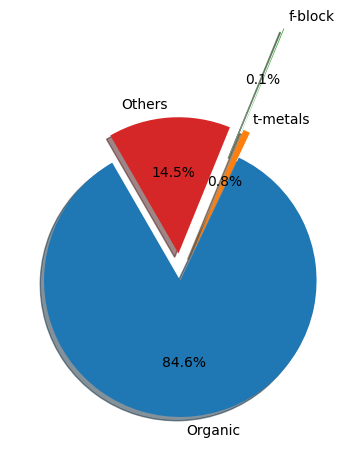

Compounds breakdown:


 Organic: 37611

 t-metals: 361

 f-block: 40

 Others: 6443

 Total: 44455


In [10]:
#draw pie chart
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Organic', 't-metals', 'f-block', 'Others'
others=len(nist_chem_list)-sum([len(nist_chem_list_organic),len(nist_chem_list_t_metals),len(nist_chem_list_f_block)])
sizes = [len(nist_chem_list_organic),len(nist_chem_list_t_metals),len(nist_chem_list_f_block), others]
explode = (0, 0.2, 1.0, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, explode=explode, labels=labels, shadow=True, startangle=120, autopct='%1.1f%%')
#fig1, ax1 = plt.subplots()
#ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#        shadow=True, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()

print("Compounds breakdown:\n")
print("\n Organic:", len(nist_chem_list_organic))
print("\n t-metals:", len(nist_chem_list_t_metals))
print("\n f-block:", len(nist_chem_list_f_block))
print("\n Others:", others)
print("\n Total:", len(nist_chem_list))


II. Распеределение молекулярных масс

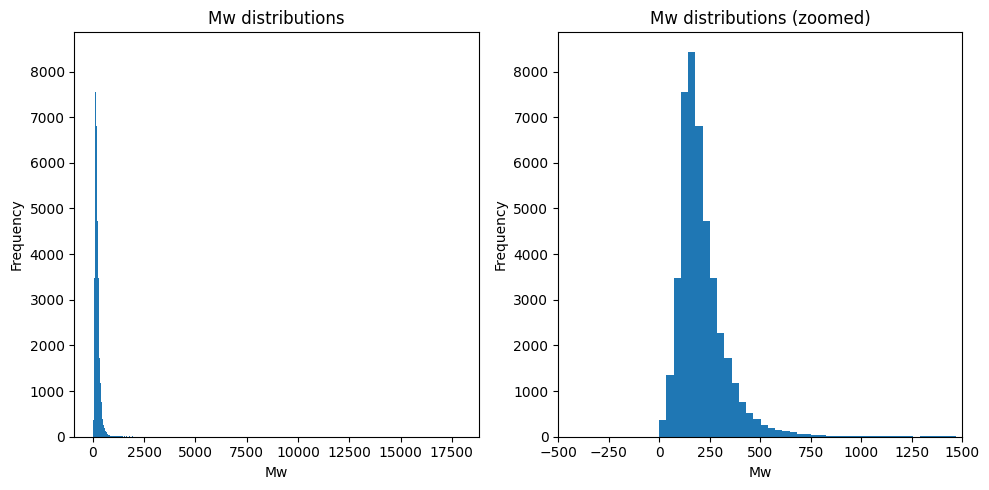

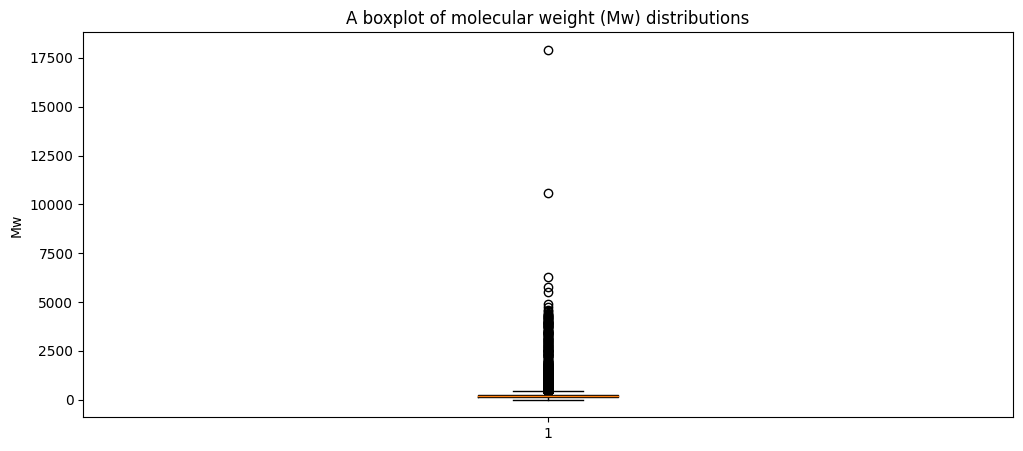



Some statistics count    44455.000000
mean       221.754239
std        231.506335
min          0.000000
25%        136.125201
50%        184.052429
75%        256.096026
max      17912.691751
Name: Mw, dtype: float64


<class 'pandas.core.frame.DataFrame'>
Index: 44455 entries, 100-00-5 to 999-97-3
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      44455 non-null  object 
 1   Formula   44455 non-null  object 
 2   Mw        44455 non-null  float64
 3   Elements  44455 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.7+ MB
Data overview None


In [11]:
# A. Generate a histogram of molecular weight distribution
# plt.figure(figsize=(20,10))

##nist_chem_list_app1.Mw.plot(kind='hist', bins=100, normed=True)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
nist_chem_list_Mw_el.Mw.plot(kind='hist', bins=500)
plt.xlabel('Mw')
plt.title('Mw distributions')

plt.subplot(1,2,2)
nist_chem_list_Mw_el.Mw.plot(kind='hist', bins=500)
plt.xlabel('Mw')
plt.xlim(-500,1500)
plt.title('Mw distributions (zoomed)')
plt.tight_layout()

# B. show a box plot of Mw distributions
plt.figure(figsize=(12,5))

# nist_chem_list_app1.Mw.plot(kind='box')
plt.boxplot(nist_chem_list_Mw_el.Mw)

plt.title('A boxplot of molecular weight (Mw) distributions')
plt.ylabel('Mw')

plt.show()

print("\n")
print("Some statistics", nist_chem_list_Mw_el.Mw.describe())
print("\n")
print("Data overview", nist_chem_list_Mw_el.info())


In [12]:
#check which compounds are in the outliers
#A. Mw=0
mw_eq_0=nist_chem_list_Mw_el[nist_chem_list_Mw_el.Mw==0]
print("No of elements with Mw=0:", len(mw_eq_0))

#check original entries
##cas_list=['25988-63-0', '26700-39-0', '26982-20-7', '61257-62-3', '61857-39-4']
#nist_chem_list.index.name

#print(nist_chem_list.head())
##df=pd.read_csv("data/NIST_chemicals_list.csv")
##df.columns=['Name','Formula','CAS']
##df.head(3)

#nist_chem_list.loc['26700-39-0']
##for i in cas_list:
##    print(df[df['CAS']==i])

#B. Mw>1000
mw_gt_1000=nist_chem_list_Mw_el[nist_chem_list_Mw_el.Mw>1000]
print("No of elements with Mw>1000:",len(mw_gt_1000))
#print(mw_gt_1000)
#print(mw_gt_1000.index)
#print(len(mw_gt_1000))

#C. Check for duplicates
print("Number of chemicals in the list:", len(nist_chem_list_Mw_el.iloc[:,0]))
print("Number of chemicals with unique CAS number in the list:", len(set(nist_chem_list_Mw_el.index)))
#There are no duplicates. Good!



No of elements with Mw=0: 5
No of elements with Mw>1000: 271
Number of chemicals in the list: 44455
Number of chemicals with unique CAS number in the list: 44455


#Скачивание и обработка спектров, полученных парсингом сайта NIST

##  Функция для скачивания

In [13]:
import urllib.request
import requests
import pandas as pd
import time
import random
from tqdm import tqdm
def download_jcamp_from_nist(cas_list, minimum_file_size=1000, start_of_files = 0, no_of_files=20):
    """ Download jcamp files from NIST website by calling out CAS values (i.e., the df index) from chemicals DataFrame, df

    Args:
    cas_list=a list consisting of CAS no.
    size=the minimum file size at which the file will be downloaded.
    no_of_files=the number of files to download.

    Returns:
    automatically saves files into the same directory as this python program.
    print the name of the downloaded files.
    name of downloaded files

    """

    # NOTE THAT SOME OF THESE FILES TURN out to be empty.
    # Need to check file size before proceeding. Don't download if empty.
    # Files are saved in the same folder as this python script.

    # Download data based on CAS number partially

    for cas_no in cas_list[start_of_files:start_of_files+no_of_files]:
        # specify CAS no. separately
        cas_num = int(cas_no.replace("-", ""))
        url = "http://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C%s&Index=1&Type=IR" % (
            cas_num) #Changed index from 0 to 1

        try:

            # Download only if size is significant. 1000 seems optimum.
            if len(requests.get(url).content) >= 1000:
                # Strip comma, apostrophe, and space in the file name because
                # it will mess up the ability of the jcamp program to read the
                # file.
                url_ret = urllib.request.urlretrieve(url, "/content/IR_expert_system/downloaded_jcamp/%s" % (cas_no))  # save file according to its cas_no
                # save by cas no.
                # url_ret = urllib.request.urlretrieve(url, "reference/%s" %(cas_no))  # save file according to its cas_no

                print(url_ret)  # print list of downloaded compounds

                # return url_ret
        except:
            continue


# End of functions

In [14]:
# DOWLOADED on the PC (will be uploaded later)
# Call out function to download. Place downloaded files into the "downloaded_jcamp" folder.
# nist_chem_list_organic=pd.read_csv('/content/IR_expert_system/data/nist_chem_list_organic.csv')
# cas_all_list = []
# for i in range(len(nist_chem_list_organic['CAS'])):
#     cas_all_list.append(nist_chem_list_organic['CAS'][i])
# nist_chem_list_f_block=pd.read_csv('/content/IR_expert_system/data/nist_chem_list_f_block.csv')
# cas_all_list = []
# for i in range(len(nist_chem_list_f_block['CAS'])):
#     cas_all_list.append(nist_chem_list_f_block['CAS'][i])
# nist_chem_list_t_metals=pd.read_csv('/content/IR_expert_system/data/nist_chem_list_t_metals.csv')
# for i in range(len(nist_chem_list_t_metals['CAS'])):
#     cas_all_list.append(nist_chem_list_t_metals['CAS'][i])

In [15]:
# batch = 20
# dowloaded = 0
# pause = random.random()/100

# for i in tqdm(range(0, len(cas_all_list)-batch ,batch)):

#     download_jcamp_from_nist(cas_all_list, 1000,start_of_files = i, no_of_files=batch)

#     dowloaded = dowloaded+1
#     time.sleep(pause)
# print(f"Parcing in finished. {dowloaded} steps of {batch} batches succesfully done!")
# # print(nist_chem_list_organic)

On the colab it does not work properly. So I made it of the my PC and upload all spectra into the git

##Считывание адресов скаченных спектров и обновление таблицы

In [16]:
import os
cas_with_ir = []
cas_with_ir_filepass = []
for dirpath, _, filenames in os.walk('/content/IR_expert_system/downloaded_jcamp/ir'):
  for filename in filenames:
     cas_with_ir.append(filename)
     cas_with_ir_filepass.append(os.path.join(dirpath, filename))
#print(cas_with_ir_filepass)
#print(cas_with_ir)
ir_spectra_dic = {}
ir_spectra_dic["CAS"] = cas_with_ir
ir_spectra_dic["Pass_to_file"] = cas_with_ir_filepass
# Create DataFrame
nist_ir_spectra_df = pd.DataFrame(ir_spectra_dic)
nist_ir_spectra_df

,CAS,Pass_to_file
0,78-78-4,/content/IR_expert_system/downloaded_jcamp/ir/...
1,7154-80-5,/content/IR_expert_system/downloaded_jcamp/ir/...
2,4726-14-1,/content/IR_expert_system/downloaded_jcamp/ir/...
3,2243-32-5,/content/IR_expert_system/downloaded_jcamp/ir/...
4,71691-56-0,/content/IR_expert_system/downloaded_jcamp/ir/...
...,...,...
14829,5049-61-6,/content/IR_expert_system/downloaded_jcamp/ir/...
14830,4116-93-2,/content/IR_expert_system/downloaded_jcamp/ir/...
14831,19770-99-1,/content/IR_expert_system/downloaded_jcamp/ir/...
14832,91391-83-2,/content/IR_expert_system/downloaded_jcamp/ir/...


In [17]:
nist_chem_list= nist_chem_list.reset_index()

In [18]:
nist_ir_spectra_list = nist_chem_list.loc[nist_chem_list['CAS'].isin(cas_with_ir)]
nist_ir_spectra_list

,CAS,Name,Formula,Mw,Elements
0,100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"[C, H, Cl, N, O]"
1,100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"[C, H, N, O]"
2,100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"[C, H, N, O]"
5,1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"[C, H, Si]"
6,1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"[C, H, Cl, Si]"
...,...,...,...,...,...
44447,99980-28-6,"Imidazole, 4-nitro-5-(propylsulfonyl)-",C6H9N3O4S,219.031377,"[C, H, N, O, S]"
44448,999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"[C, H, Cl, N, Cl]"
44449,99983-48-9,"Alpha,alpha-dichloropropionic acid, 2-(2,4-dib...",C11H10Br2Cl2O3,417.837375,"[C, H, Br, Cl, O]"
44452,99-99-0,"Benzene, 1-methyl-4-nitro-",C7H7NO2,137.047678,"[C, H, N, O]"


In [19]:
nist_ir_spectra_list.set_index('CAS').join(nist_ir_spectra_df.set_index('CAS'))

,Name,Formula,Mw,Elements,Pass_to_file
CAS,,,,,
100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"[C, H, Cl, N, O]",/content/IR_expert_system/downloaded_jcamp/ir/...
100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"[C, H, N, O]",/content/IR_expert_system/downloaded_jcamp/ir/...
100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"[C, H, N, O]",/content/IR_expert_system/downloaded_jcamp/ir/...
1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"[C, H, Si]",/content/IR_expert_system/downloaded_jcamp/ir/...
1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"[C, H, Cl, Si]",/content/IR_expert_system/downloaded_jcamp/ir/...
...,...,...,...,...,...
99980-28-6,"Imidazole, 4-nitro-5-(propylsulfonyl)-",C6H9N3O4S,219.031377,"[C, H, N, O, S]",/content/IR_expert_system/downloaded_jcamp/ir/...
999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"[C, H, Cl, N, Cl]",/content/IR_expert_system/downloaded_jcamp/ir/...
99983-48-9,"Alpha,alpha-dichloropropionic acid, 2-(2,4-dib...",C11H10Br2Cl2O3,417.837375,"[C, H, Br, Cl, O]",/content/IR_expert_system/downloaded_jcamp/ir/...


##Формирование списка скачанных спектров.

In [20]:
from IPython.core.display import clear_output
!pip install --upgrade jcamp
clear_output()

In [21]:
# Plot one spectra that are located in the "downloaded_jcamp" folder
# Use jcamp codes to read jcamp files using jcamp package (taken from:
# https://pypi.python.org/pypi/jcamp/1.2.1).

import jcamp
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# Create an empty list to store spectra data
ref_spectra = []


# choose current directory
curr_directory = os.getcwd()
os.chdir(curr_directory)  # set to current directory
files = glob.glob('/content/IR_expert_system/downloaded_jcamp/*')  # look for files without extension. Returns a list.

In [22]:
from jcamp import jcamp_readfile
sample = jcamp_readfile(files[0])
print(sample)
print(sample["y"])

{'title': 'Butane, 2-methyl-', 'jcamp-dx': 4.24, 'data type': 'INFRARED SPECTRUM', 'class': 'COBLENTZ', 'origin': 'DOW CHEMICAL COMPANY', 'owner': 'Copyright (C) 1987 by the Coblentz Society\nCollection (C) 2018 copyright by the U.S. Secretary of Commerce\non behalf of the United States of America. All rights reserved.', 'date': 1964, 'names': 'isopentane\nISOPENTANE', 'cas registry no': '78-78-4', 'molform': 'C5 H12', 'source reference': 'COBLENTZ NO. 8874', '$nist source': 'COBLENTZ', '$nist image': 'cob8874', 'spectrometer/data system': 'DOW KBr FOREPRISM-GRATING', 'instrument parameters': 'GRATING CHANGED AT 5.0, 7.5, 15.0 MICRON', 'state': 'GAS (100 mmHg, N2 ADDED, TOTAL PRESSURE 600 mmHg)', 'path length': '5 CM', 'sampling procedure': 'TRANSMISSION', 'resolution': 2, 'data processing': 'DIGITIZED BY COBLENTZ SOCIETY (BATCH II) FROM HARD COPY', 'xunits': '1/CM', 'yunits': 'TRANSMITTANCE', 'xfactor': 1.0, 'yfactor': 1, 'firstx': 460, 'lastx': 3792, 'firsty': 0.8534, 'maxx': 3792, '

Функция чтения спектров

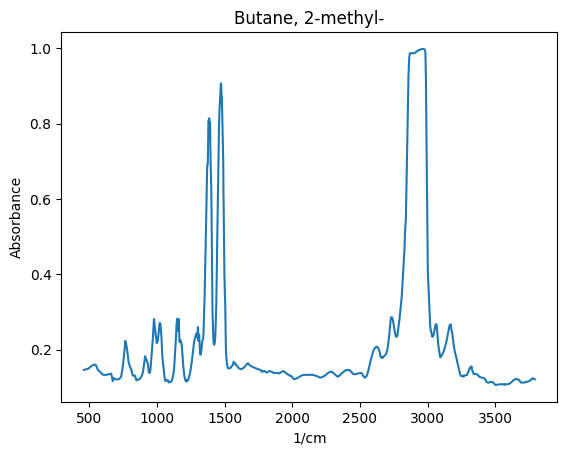

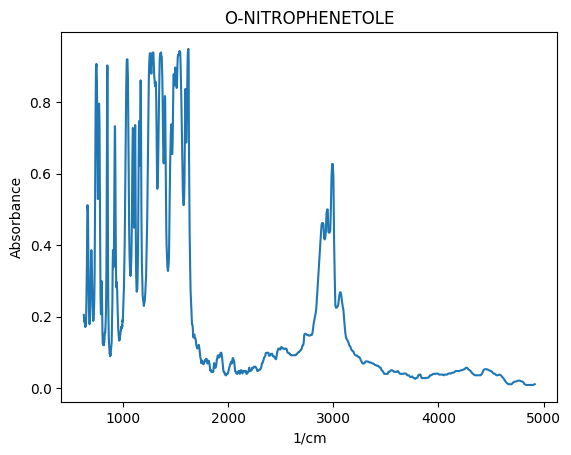

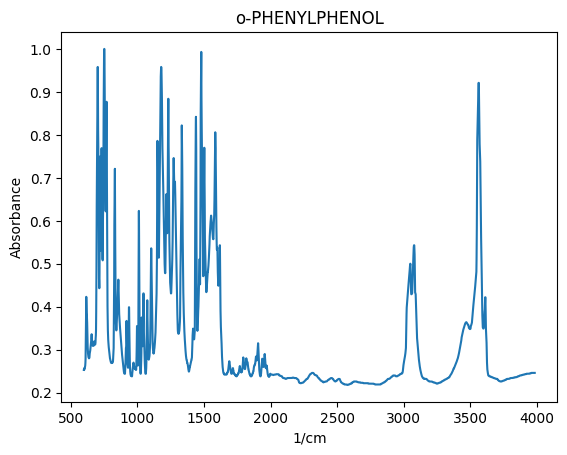

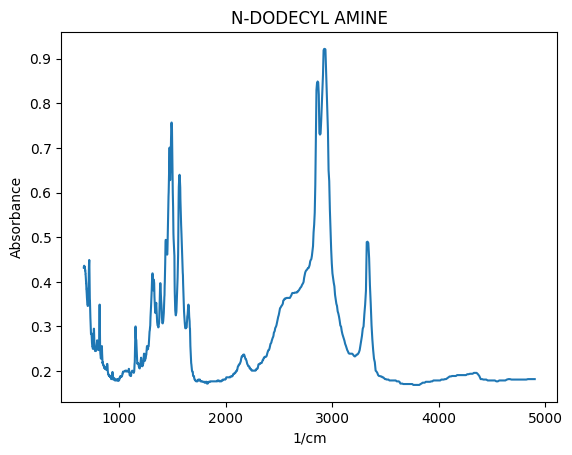

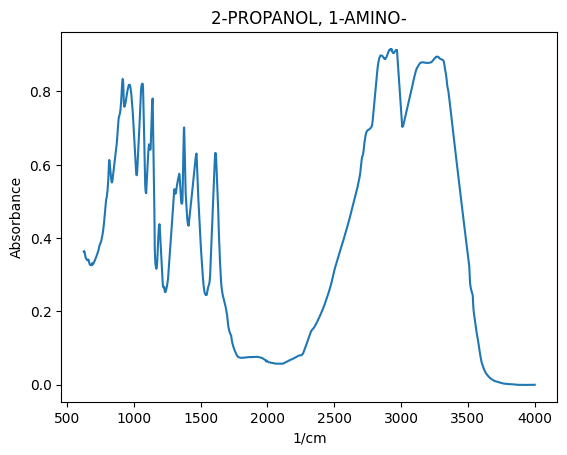

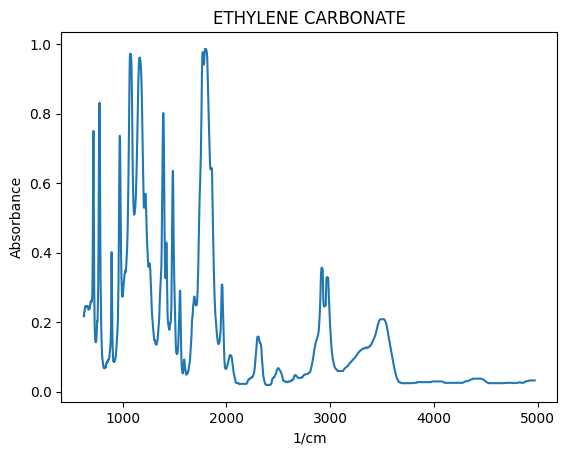

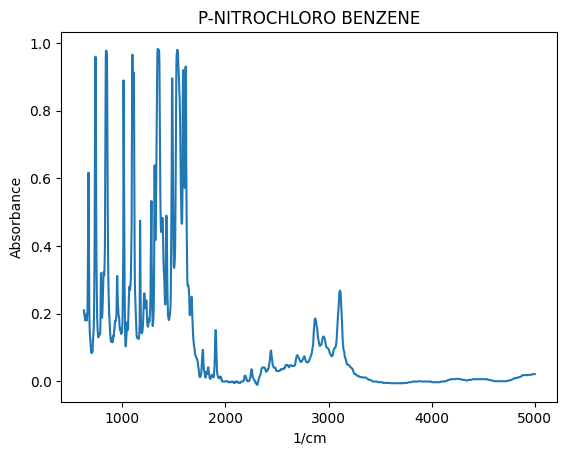

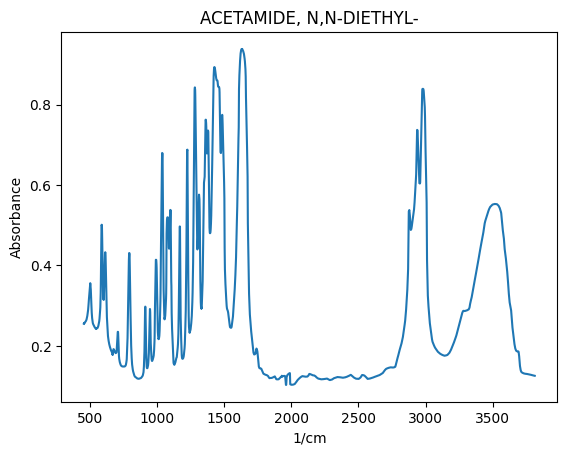

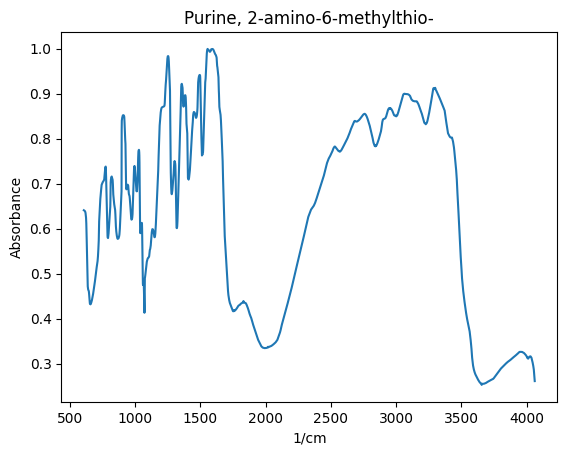

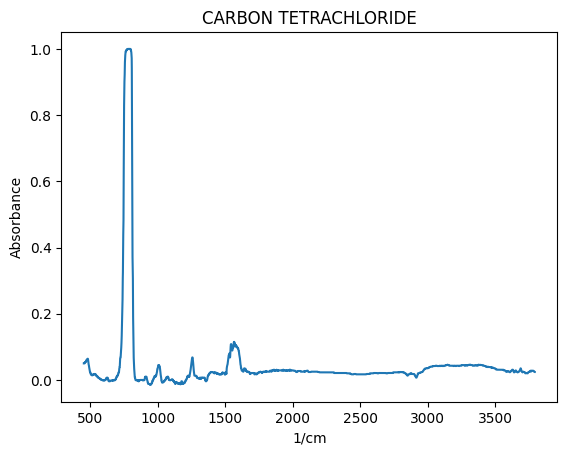

In [23]:
# Try to read the file. If can't be read, skip it.
for i, file in enumerate(files[:10]):

    #print(file)
    try:
        # read jcamp file using the jcamp class and store data into the
        # ref_spectra list
        sample = jcamp_readfile(file)
        ref_spectra.append(sample)

        #print(ref_spectra[i])
        #print(ref_spectra[i]['x'])
        #print(ref_spectra[i]['y'])

        # uniformize data, #1:
        # check yunits: If yunits is in transmission, change it to absorbance.
        # Later create a function to uniformize units
        if ref_spectra[i]['yunits'] == "ABSORBANCE":
            pass

        elif ref_spectra[i]['yunits'] == "TRANSMISSION" or "TRANSMITTANCE":

            ref_spectra[i]['y'] = 1 - ref_spectra[i]['y']
            #normalize
            #ref_spectra[i]['y'] = (ref_spectra[i]['y']-min(ref_spectra[i]['y'])) / max(ref_spectra[i]['y'])

        # check xunits: if in microns, change to 1/cm
        if ref_spectra[i]['xunits'] == "MICROMETERS":
            ref_spectra[i]['x'] = 10000 / ref_spectra[i]['x']

        # uniformize data, #2:
        # normalize absorbance peaks (y-values) to between 0 and 1.
        #ref_spectra[i]['y'] = (ref_spectra[i]['y']-min(ref_spectra[i]['y'])) / max(ref_spectra[i]['y'])

        # !Still need to uniformize x-axis range and uniformize x-axis intervals.



        # Nan check
        if np.isnan(ref_spectra[i]['y']).any(): print("Reading jcamp problem! Nan observed in Y")

        # plot data to allow visual inspections
        plt.plot(ref_spectra[i]['x'], ref_spectra[i]['y'])
        plt.title(ref_spectra[i]["title"])
        plt.xlabel('1/cm')
        plt.ylabel('Absorbance')
        plt.show()

    except:
        # print("File can't be read, please check:", files)
         continue

##Дополнение списка ключами InChi/SMILES

Убрана под комментарий из-за времени работы. Все ключи скачаны и записаны в csv файл.

In [24]:
# from urllib.request import urlopen

# #Функция для конвертации онлайн CAS номера в SMILES или Standart InChi описание молекулы

# def CasToInChiconvert(cas):
#     try:
#         url = 'http://cactus.nci.nih.gov/chemical/structure/' + cas + '/stdinchi'
#         ans = urlopen(url).read().decode('utf8')
#         return ans
#     except:
#         return cas

# def CasToSMILESconvert(cas):
#     try:
#         url = 'http://cactus.nci.nih.gov/chemical/structure/' + cas + '/smiles'
#         ans = urlopen(url).read().decode('utf8')
#         return ans
#     except:
#         return cas

# casno = ['50-78-2', '69-72-7', '95-1E-6', '108-24-7', '31710-30-2']

# for casid in casno:
#     print(CasToSMILESconvert(casid))

In [25]:
!pip install cirpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import cirpy
def cirpy_cas_to_smiles(cas):
  return cirpy.resolve(cas, 'smiles')
def cirpy_cas_to_inchi(cas):
  return cirpy.resolve(cas, 'inchi')

Добавим в таблицу к имеющимся CAS ключи SMILES и InChi. Занимает порядка 24 часов. Поэтому все ключи сохранены и загружены на Git. В дальнейшем импортируется из гита. А код убран под комментарий.

In [27]:
# from tqdm import tqdm
# smiles_list = []
# inchi_list = []

# for casno in tqdm(nist_ir_spectra_list["CAS"]):
#   smile = cirpy_cas_to_smiles(casno)
#   smiles_list.append(smile)
#   inchi_list.append(cirpy_cas_to_inchi(casno))

# nist_ir_spectra_list["InChi"] = inchi_list
# nist_ir_spectra_list["SMILES"] = smiles_list

# nist_ir_spectra_list

In [28]:
# nist_ir_spectra_list.to_csv("/content/IR_expert_system/data/nist_ir_spectra_list.csv")

In [29]:
nist_ir_spectra_list = pd.read_csv("/content/IR_expert_system/data/nist_ir_spectra_list.csv")
#nist_ir_spectra_list=nist_ir_spectra_list.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])
nist_ir_spectra_list = nist_ir_spectra_list.dropna()
nist_ir_spectra_list

,Unnamed: 0,CAS,Name,Formula,Mw,Elements,InChi,SMILES
0,0,100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1
1,1,100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O
2,2,100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O
3,5,1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C
4,6,1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl
...,...,...,...,...,...,...,...,...
14661,44445,99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1
14662,44446,999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C
14664,44448,999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl
14666,44452,99-99-0,"Benzene, 1-methyl-4-nitro-",C7H7NO2,137.047678,"['C', 'H', 'N', 'O']","InChI=1/C7H7NO2/c1-6-2-4-7(5-3-6)8(9)10/h2-5H,1H3",Cc1ccc(cc1)[N+]([O-])=O


#Разметка на 17 классов по функциональным группам


In [30]:
#Функция для генерации бинарных меток присутствия функциональных групп
#From https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning
import os
import logging
import argparse
import sys
import datamol as dm
import pandas as pd
import numpy as np

from rdkit import Chem, RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

#from model.utils import set_logger
print('imports loaded')
func_grp_smarts = {'alkane':'[CX4;H0,H1,H2,H4]',
                   'methyl':'[CH3]',
                   'alkene':'[CX3]=[CX3]',
                   'alkyne':'[CX2]#C',
                   'alcohols':'[#6][OX2H]',
                   'amines':'[NX3;H2,H1;!$(NC=O)]',
                   'nitriles':'[NX1]#[CX2]',
                   'aromatics':'[$([cX3](:*):*),$([cX2+](:*):*)]',
                   'alkyl halides':'[#6][F,Cl,Br,I]',
                   'esters':'[#6][CX3](=O)[OX2H0][#6]',
                   'ketones':'[#6][CX3](=O)[#6]',
                   'aldehydes':'[CX3H1](=O)[#6]',
                   'carboxylic acids':'[CX3](=O)[OX2H1]',
                   'ether': '[OD2]([#6])[#6]',
                   'acyl halides':'[CX3](=[OX1])[F,Cl,Br,I]',
                   'amides':'[NX3][CX3](=[OX1])[#6]',
                   'nitro':'[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]'}

def identify_functional_groups(inchi):
    '''Identify the presence of functional groups present in molecule
       denoted by inchi

    Returns:
        mol_func_groups: (list) contains binary values of functional groups presence
                          None if inchi to molecule conversion returns warning or error
    '''

    try:
        #Convert inchi to molecule
        mol = Chem.MolFromInchi(inchi, treatWarningAsError=True)
        mol_func_grps = []
        #mol1 = dm.to_mol(inchi, sanitize=True)
        #dm.viz.to_image(mol1)
        #populate the list with group values
        for _, func_struct in func_grp_structs.items():

            #print(func_struct)
            dm.viz.to_image(func_struct)
            struct_matches = mol.GetSubstructMatches(func_struct)
            #print(struct_matches)
            contains_func_grp = int(len(struct_matches)>0)
            #print(contains_func_grp)
            mol_func_grps.append(contains_func_grp)
        return mol_func_grps
    except:

        return None

def save_target_to_csv(cas_inchi_df, save_path):
    '''Save the target dataframe as csv to path

    Args:
        cas_inchi_df: (pd.DataFrame) contains CAS and Inchi of molecules
        save_path: (string) path to store csv file

    Returns:
        None
    '''
    column_names = list(func_grp_structs.keys())
    target_df = pd.DataFrame(index = cas_inchi_df.index, columns = column_names)

    #Iterate the rows, don't use df.apply since a list is being returned.
    for ind, (_, row) in enumerate(cas_inchi_df.iterrows()):
        target_df.iloc[ind, :] = identify_functional_groups(row['inchi'])


    target_df.dropna(inplace = True)
    target_df.to_csv(save_path)
    return target_df


imports loaded


In [31]:
    # #Parsing the data from jdx and storing it in csv

    # func_grp_structs = {func_name : Chem.MolFromSmarts(func_smarts)\
    #                     for func_name, func_smarts in func_grp_smarts.items()}
    # print('funcgrpstruct')
    # #print(func_grp_structs)


    # logging.info('Loading inchi file from /content/IR_expert_system/data/nist_ir_spectra_list.csv')
    # inchi_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_list.csv', header = 0, usecols = [1,6],\
    #                     names = ['CAS','inchi'], dtype = str)
    # #print(inchi_df)

    # inchi_df.dropna(inplace = True)
    # inchi_df.set_index('CAS', inplace = True)

    # # Create and save csv of target
    # target_path = os.path.join('/content/IR_expert_system/data', 'target.csv')

    # save_target_to_csv(inchi_df, target_path)
    # target = pd.read_csv("/content/IR_expert_system/data/target.csv")
    # target

In [32]:
#nist_ir_spectra_list_with_group = nist_ir_spectra_list.set_index('CAS').join(target.set_index('CAS'))
# nist_ir_spectra_list_with_group

In [33]:
# nist_ir_spectra_list_with_group.to_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')

## Визуализация 17 классового датасета.
Таблица данных о скачанных спектрах сформирована. Ключи и метки классов присвоены и сведены в таблицу. Требуется понять статитстику по спектрам.

In [34]:
nist_ir_spectra_list_with_group = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
nist_ir_spectra_list_with_group

,CAS,Name,Formula,Mw,Elements,InChi,SMILES,alkane,methyl,alkene,...,aromatics,alkyl halides,esters,ketones,aldehydes,carboxylic acids,ether,acyl halides,amides,nitro
0,100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12228,99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12229,999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12230,999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12231,99-99-0,"Benzene, 1-methyl-4-nitro-",C7H7NO2,137.047678,"['C', 'H', 'N', 'O']","InChI=1/C7H7NO2/c1-6-2-4-7(5-3-6)8(9)10/h2-5H,1H3",Cc1ccc(cc1)[N+]([O-])=O,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
nist_ir_spectra_list_with_group.drop("Mw", axis = 1).describe()

,alkane,methyl,alkene,alkyne,alcohols,amines,nitriles,aromatics,alkyl halides,esters,ketones,aldehydes,carboxylic acids,ether,acyl halides,amides,nitro
count,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.00000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000,12224.000000
mean,0.679565,0.618701,0.134162,0.019061,0.222186,0.129990,0.03804,0.585733,0.260062,0.117147,0.092850,0.020370,0.061355,0.250900,0.009735,0.070517,0.057428
std,0.466663,0.485726,0.340841,0.136745,0.415732,0.336306,0.19130,0.492615,0.438686,0.321608,0.290234,0.141267,0.239990,0.433549,0.098188,0.256027,0.232668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
mean_of_groups = nist_ir_spectra_list_with_group.drop("Mw", axis = 1).describe().drop(['count', 'std', 'min', '25%', '50%', '75%', 'max'])
mean_of_groups = mean_of_groups.values.tolist()
print(mean_of_groups)

[[0.6795647905759162, 0.6187009162303665, 0.13416230366492146, 0.019060863874345548, 0.22218586387434555, 0.1299901832460733, 0.03803992146596859, 0.5857329842931938, 0.2600621727748691, 0.11714659685863875, 0.09285013089005235, 0.02036976439790576, 0.061354712041884814, 0.25089986910994766, 0.009734947643979058, 0.07051701570680628, 0.05742801047120419]]


In [37]:
groups_names = nist_ir_spectra_list_with_group.drop("Mw", axis = 1).describe().columns.values
print(groups_names)

['alkane' 'methyl' 'alkene' 'alkyne' 'alcohols' 'amines' 'nitriles'
 'aromatics' 'alkyl halides' 'esters' 'ketones' 'aldehydes'
 'carboxylic acids' 'ether' 'acyl halides' 'amides' 'nitro']


<BarContainer object of 17 artists>

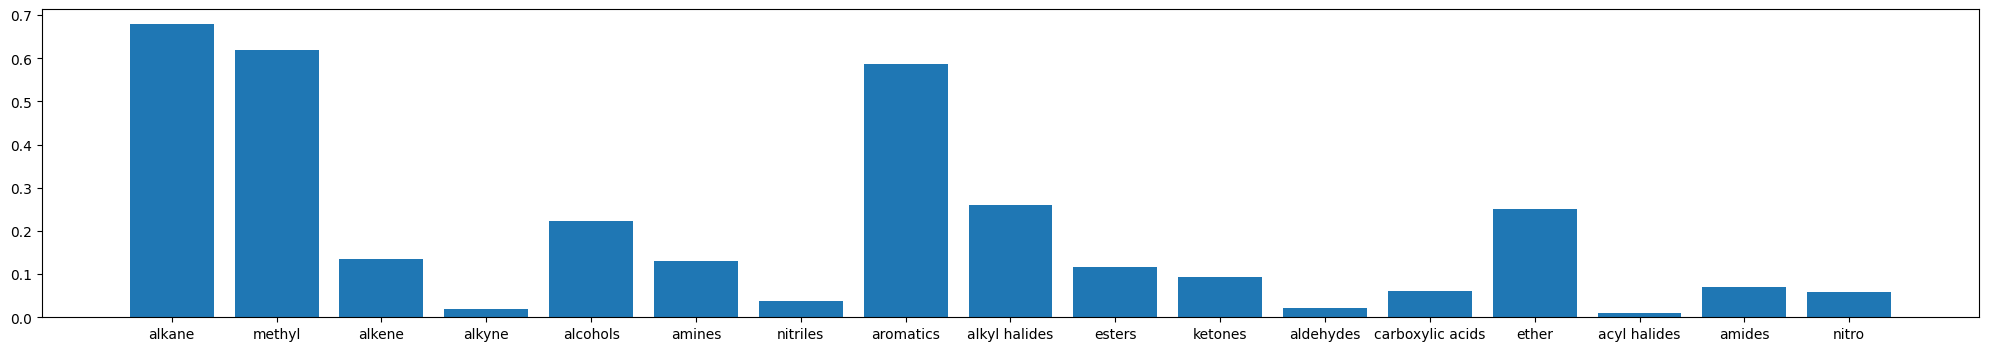

In [38]:
plt.figure(figsize = (25,4))
plt.bar(groups_names, mean_of_groups[0])

In [39]:
sum1 = nist_ir_spectra_list_with_group.sum()

In [94]:
sum1

CAS                 100-00-5100-01-6100-02-71000-49-31000-50-6100-...
Name                Benzene, 1-chloro-4-nitro-p-NitroanilinePhenol...
Formula             C6H4ClNO2C6H6N2O2C6H5NO3C7H18SiC6H15ClSiC9H10O...
Mw                                                     2396515.743518
Elements            ['C', 'H', 'Cl', 'N', 'O']['C', 'H', 'N', 'O']...
InChi               InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4...
SMILES              [O-][N+](=O)c1ccc(Cl)cc1Nc1ccc(cc1)[N+]([O-])=...
alkane                                                         8307.0
methyl                                                         7563.0
alkene                                                         1640.0
alkyne                                                          233.0
alcohols                                                       2716.0
amines                                                         1589.0
nitriles                                                        465.0
aromatics           

In [93]:
sum2 = sum1[5:]

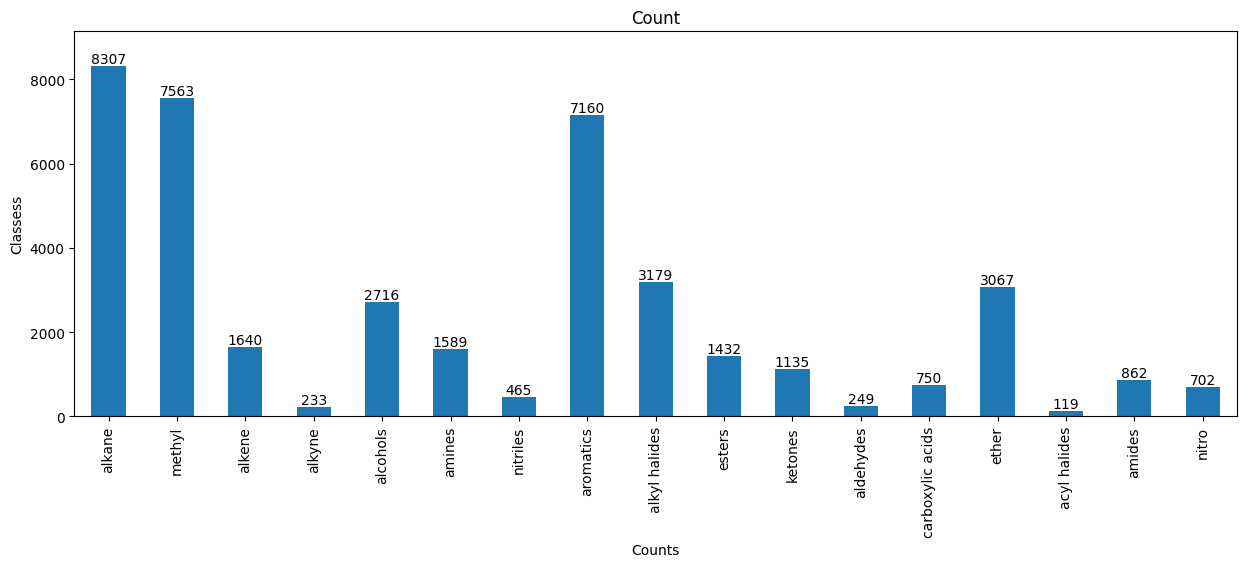

In [92]:
df = pd.DataFrame(sum2)
# plot
ax = df.plot(kind='bar', figsize=(15, 5), title='Count',
             xlabel='Counts', ylabel='Classess', legend=False)

# annotate
ax.bar_label(ax.containers[0], label_type='edge')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

Наблюдается сильный дисбаланс классов, что требует применения кроме бинарной кросс-энтропии для мультиклассовой модели, еще и правильного формирования батчей.

#Разметка на 92 (72) класса по полосам поглощения отдельных колебаний

## Создание таблицы всех известных колебаний

In [42]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def create_all_bonds_types_table():
  # Request information from wikipedia
  res = requests.get(
        "https://en.wikipedia.org/wiki/Infrared_spectroscopy_correlation_table")

  # Create a BeautifulSoup class
  soup = BeautifulSoup(res.content, 'lxml')

  # Extract info. from a table
  table = soup.find_all(class_="wikitable")[0]

  # Load table info. into a Pandas DataFrame
  df = pd.read_html(str(table), header=0)[0]
  return df

In [43]:
all_bonds_types_table = create_all_bonds_types_table()
all_bonds_types_table

,Bond,Type of bond,Specific type of bond,Absorption peak (cm−1),Appearance
0,C─H,alkyl,methyl,1260,strong
1,C─H,alkyl,methyl,1380,weak
2,C─H,alkyl,methyl,2870,medium to strong
3,C─H,alkyl,methyl,2960,medium to strong
4,C─H,alkyl,methylene,1470,strong
...,...,...,...,...,...
87,N─O,nitro compounds,aromatic,1520,lower if conjugated
88,N─O,nitro compounds,aromatic,1350,lower if conjugated
89,P─C,Organophosphorus compound,aromatic,1440-1460,medium
90,P─O,phosphorus oxide,bonded,1195-1250,strong


In [44]:
num_list = []
for i in range(len(all_bonds_types_table['Absorption peak (cm−1)'])):
  temp = all_bonds_types_table['Absorption peak (cm−1)'][i]
  try:
    num_list.append(int(temp))
  except:

    if ">" in temp:
        num = temp[1:]
        num = int(num)
        num_list.append(num)
    elif '–' in temp:
        num_list1 = temp.split('–')
        num = (int(num_list1[0])+int(num_list1[1]))/2
        num_list.append(num)
    elif '-' in temp:
        num_list2 = temp.split('-')
        num = (int(num_list2[0])+int(num_list2[1]))/2
        num_list.append(num)
    elif '~' in temp:
        num = temp[1:]
        num = int(num)
        num_list.append(num)
print(num_list)
all_bonds_types_table['Absorption peak (cm−1) num'] = num_list

[1260, 1380, 2870, 2960, 1470, 2850, 2925, 2890, 900, 2975, 3080, 3020, 900, 990, 685.0, 965, 820.0, 3070, 725.0, 700.0, 750, 775.0, 880.0, 830.0, 3300, 2720, 2820, 1645, 1655, 1660, 1675, 1670, 1600, 1650, 1625, 1600, 1660.0, 1450, 1500, 1580, 1600, 2120.0, 2225.0, 1720, 1685, 1685, 1750, 1775, 1725, 1710, 1685.0, 1735, 1760, 1820, 1800, 1650, 1580.0, 1580.0, 3640.0, 3300.0, 3530.0, 3000, 3450.0, 1600.0, 3000, 2800.0, 1050.0, 1100, 1175.0, 1200, 1120, 1240.0, 1275.0, 1200.0, 1120.0, 1657.5, 2250, 2230, 2137.5, 2065.0, 1050.0, 1150.0, 650.0, 550.0, 500, 1540, 1380, 1520, 1350, 1450.0, 1222.5, 1275.0]


In [45]:
print(all_bonds_types_table.to_string())

   Bond                Type of bond               Specific type of bond Absorption peak (cm−1)                                                          Appearance  Absorption peak (cm−1) num
0   C─H                       alkyl                              methyl                   1260                                                              strong                      1260.0
1   C─H                       alkyl                              methyl                   1380                                                                weak                      1380.0
2   C─H                       alkyl                              methyl                   2870                                                    medium to strong                      2870.0
3   C─H                       alkyl                              methyl                   2960                                                    medium to strong                      2960.0
4   C─H                       alkyl          

In [46]:
bond_type_cls_list = []
for i in range(len(all_bonds_types_table)):
  bond_type_cls = ""
  for st in list(all_bonds_types_table.iloc[i])[:-1]:
    bond_type_cls += str(st)+' '
  bond_type_cls_list.append(bond_type_cls)
print(bond_type_cls_list)

['C─H alkyl methyl 1260 strong ', 'C─H alkyl methyl 1380 weak ', 'C─H alkyl methyl 2870 medium to strong ', 'C─H alkyl methyl 2960 medium to strong ', 'C─H alkyl methylene 1470 strong ', 'C─H alkyl methylene 2850 medium to strong ', 'C─H alkyl methylene 2925 medium to strong ', 'C─H alkyl methine 2890 weak ', 'C─H vinyl C═CH2 900 strong ', 'C─H vinyl C═CH2 2975 medium ', 'C─H vinyl C═CH2 3080 medium ', 'C─H vinyl C═CH 3020 medium ', 'C─H vinyl monosubstituted alkenes 900 strong ', 'C─H vinyl monosubstituted alkenes 990 strong ', 'C─H vinyl cis-disubstituted alkenes 670–700 strong ', 'C─H vinyl trans-disubstituted alkenes 965 strong ', 'C─H vinyl trisubstituted alkenes 800–840 strong to medium ', 'C─H aromatic benzene/sub. benzene 3070 weak ', 'C─H aromatic monosubstituted benzene 700–750 strong ', 'C─H aromatic monosubstituted benzene 690–710 strong ', 'C─H aromatic ortho-disub. benzene 750 strong ', 'C─H aromatic meta-disub. benzene 750–800 strong ', 'C─H aromatic meta-disub. benzene 

In [47]:
for i in range(len(bond_type_cls_list)):
  print("'" + bond_type_cls_list[i]+"': ," )

'C─H alkyl methyl 1260 strong ': ,
'C─H alkyl methyl 1380 weak ': ,
'C─H alkyl methyl 2870 medium to strong ': ,
'C─H alkyl methyl 2960 medium to strong ': ,
'C─H alkyl methylene 1470 strong ': ,
'C─H alkyl methylene 2850 medium to strong ': ,
'C─H alkyl methylene 2925 medium to strong ': ,
'C─H alkyl methine 2890 weak ': ,
'C─H vinyl C═CH2 900 strong ': ,
'C─H vinyl C═CH2 2975 medium ': ,
'C─H vinyl C═CH2 3080 medium ': ,
'C─H vinyl C═CH 3020 medium ': ,
'C─H vinyl monosubstituted alkenes 900 strong ': ,
'C─H vinyl monosubstituted alkenes 990 strong ': ,
'C─H vinyl cis-disubstituted alkenes 670–700 strong ': ,
'C─H vinyl trans-disubstituted alkenes 965 strong ': ,
'C─H vinyl trisubstituted alkenes 800–840 strong to medium ': ,
'C─H aromatic benzene/sub. benzene 3070 weak ': ,
'C─H aromatic monosubstituted benzene 700–750 strong ': ,
'C─H aromatic monosubstituted benzene 690–710 strong ': ,
'C─H aromatic ortho-disub. benzene 750 strong ': ,
'C─H aromatic meta-disub. benzene 750–800 str

In [48]:
# Number of classes
num_classes = len(bond_type_cls_list)
num_classes

92

In [49]:
cls2indx_bonds = {}
indx2cls_bonds = {}
for i, classs in enumerate(bond_type_cls_list):
  cls2indx_bonds[f'{classs}']= i
  indx2cls_bonds[i] = classs
print(cls2indx_bonds)
print(indx2cls_bonds)

{'C─H alkyl methyl 1260 strong ': 0, 'C─H alkyl methyl 1380 weak ': 1, 'C─H alkyl methyl 2870 medium to strong ': 2, 'C─H alkyl methyl 2960 medium to strong ': 3, 'C─H alkyl methylene 1470 strong ': 4, 'C─H alkyl methylene 2850 medium to strong ': 5, 'C─H alkyl methylene 2925 medium to strong ': 6, 'C─H alkyl methine 2890 weak ': 7, 'C─H vinyl C═CH2 900 strong ': 8, 'C─H vinyl C═CH2 2975 medium ': 9, 'C─H vinyl C═CH2 3080 medium ': 10, 'C─H vinyl C═CH 3020 medium ': 11, 'C─H vinyl monosubstituted alkenes 900 strong ': 12, 'C─H vinyl monosubstituted alkenes 990 strong ': 13, 'C─H vinyl cis-disubstituted alkenes 670–700 strong ': 14, 'C─H vinyl trans-disubstituted alkenes 965 strong ': 15, 'C─H vinyl trisubstituted alkenes 800–840 strong to medium ': 16, 'C─H aromatic benzene/sub. benzene 3070 weak ': 17, 'C─H aromatic monosubstituted benzene 700–750 strong ': 18, 'C─H aromatic monosubstituted benzene 690–710 strong ': 19, 'C─H aromatic ortho-disub. benzene 750 strong ': 20, 'C─H aromati

## Приписание 92 классов по SMARTs ключам

### Создание словаря для 92 (72) классов и проверка работоспособности

По аналогии со словарём для 17 классов, вручную был создан словарь на 92 класса по таблице всех известных колебаний.

In [50]:
 #Словарь SMART ключей для поиска отдельных подклассов 1/92
all_bonds_types_strs = {
'C─H alkyl methyl 1260 strong': '[CH3]',
'C─H alkyl methyl 1380 weak': '[CH3]',
'C─H alkyl methyl 2870 medium to strong': '[CH3]',
'C─H alkyl methyl 2960 medium to strong': '[CH3]',
'C─H alkyl methylene 1470 strong': '[CX4;H2]',
'C─H alkyl methylene 2850 medium to strong': '[CX4;H2]',
'C─H alkyl methylene 2925 medium to strong': '[CX4;H2]',
'C─H alkyl methine 2890 weak': '[CX4;H1]',
'C─H vinyl C═CH2 900 strong': '[CX3]=[CH2]',
'C─H vinyl C═CH2 2975 medium': '[CX3]=[CH2]',
'C─H vinyl C═CH2 3080 medium': '[CX3]=[CH2]',
'C─H vinyl C═CH 3020 medium': '[CX3]=[CX3;H1]',
'C─H vinyl monosubstituted alkenes 900 strong': '[CX3;H2]=[CX3;H1]',
'C─H vinyl monosubstituted alkenes 990 strong': '[CX3;H2]=[CX3;H1]',
'C─H vinyl cis-disubstituted alkenes 670–700 strong': '*\[CX3;H1]=[CX3;H1]/*', #Проверить работу цис-транс-изомерии
'C─H vinyl trans-disubstituted alkenes 965 strong': '*/[CX3;H1]=[CX3;H1]/*',
'C─H vinyl trisubstituted alkenes 800–840 strong to medium': '[CX3;H1]=[CX3;H0]',
'C─H aromatic benzene/sub. benzene 3070 weak': '[c;H1]',
'C─H aromatic monosubstituted benzene 700–750 strong': '[c;!H1]1[c;H1][c;H1][c;H1][c;H1][c;H1]1',
'C─H aromatic monosubstituted benzene 690–710 strong': '[c;!H1]1[c;H1][c;H1][c;H1][c;H1][c;H1]1',
'C─H aromatic ortho-disub. benzene 750 strong': '[c;!H1]1[c;H1][c;H1][c;H1][c;H1][c;!H1]1',
'C─H aromatic meta-disub. benzene 750–800 strong': '[c;!H1]1[c;H1][c;H1][c;H1][c;!H1][c;H1]1',
'C─H aromatic meta-disub. benzene 860–900 strong': '[c;!H1]1[c;H1][c;H1][c;H1][c;!H1][c;H1]1',
'C─H aromatic para-disub. benzene 800–860 strong': '[c;!H1]1[c;H1][c;H1][c;!H1][c;H1][c;H1]1',
'C─H alkynes any 3300 medium': '[CH1]#C',
'C─H aldehydes any 2720 medium': '[CX3H1](=O)',
'C─H aldehydes any 2820 medium': '[CX3H1](=O)',
'C═C acyclic C═C monosub. alkenes 1645 medium': '[CX3;H1]=[CH2]',
'C═C acyclic C═C 1,1-disub. alkenes 1655 medium': '[CX3;!H1,!H2]=[CH2]',
'C═C acyclic C═C cis-1,2-disub. alkenes 1660 medium': '[!H]\[CX3;!H2,H1]=[CX3;!H2,H1]/[!H]',#Проверить работу цис-транс-изомерии
'C═C acyclic C═C trans-1,2-disub. alkenes 1675 medium': '[!H]\[CX3;!H2,H1]=[CX3;!H2,H1]/[!H]',#Проверить работу цис-транс-изомерии
'C═C acyclic C═C trisub., tetrasub. alkenes 1670 weak': ['[CX3]=[CX3;H0]','[CX3;H0]=[CX3;H0]'],
'C═C conjugated C═C dienes 1600 strong': '[CX3]=[CX3][CX3]=[CX3]',
'C═C conjugated C═C dienes 1650 strong': '[CX3]=[CX3][CX3]=[CX3]',
'C═C with benzene ring dienes 1625 strong': '[CX3]=[CX3]с1ссссс1',
'C═C with C═O dienes 1600 strong': '[CX3]=[CX3][CX3]=[O]',
'C═C C═C (both sp2) any 1640–1680 medium': '[CX3]=[CX3]',
'C═C aromatic C═C any 1450 weak to strong (usually 3 or 4)': 'cc',
'C═C aromatic C═C any 1500 weak to strong (usually 3 or 4)': 'cc',
'C═C aromatic C═C any 1580 weak to strong (usually 3 or 4)': 'cc',
'C═C aromatic C═C any 1600 weak to strong (usually 3 or 4)': 'cc',
'C═C C≡C terminal alkynes 2100–2140 weak': '[CH1]#C',
'C═C C≡C disubst. alkynes 2190–2260 very weak (often indistinguishable)': '[CD2]#[CD2]', #Проверить работоспособность
'C=O aldehyde/ketone saturated aliph./cyclic 6-membered 1720 ': ['[#6][CX3](=O)[#6]', '[CX3H1](=O)[#6]', '[r6][CX3](=O)', '[r6][CX3H1](=O)'],
'C=O aldehyde/ketone α,β-unsaturated 1685 ': ['[CX3]=[CX3][CX3](=O)[#6]','[CX3]=[CX3][#6][CX3](=O)[#6]', '[CX3]=[CX3][CX3H1](=O)','[CX3]=[CX3][#6][CX3H1](=O)'],
'C=O aldehyde/ketone aromatic ketones 1685 ': 'c[CX3](=O)',
'C=O aldehyde/ketone cyclic 5-membered 1750 ': ['[r5][CX3O1](=O)', '[#6]1[#6][#6][#6][#6]1[CX3O1](=O)'],
'C=O aldehyde/ketone cyclic 4-membered 1775 ': ['[r4][CX3O1](=O)', '[#6]1[#6][#6][#6]1[CX3O1](=O)'],
'C=O aldehyde/ketone aldehydes 1725 influenced by conjugation (as with ketones)': '[#6][CX3H1](=O)',
'C=O carboxylic acids/derivates saturated carboxylic acids 1710 ': '[!$(*#C),!$(*=C)][CX3](=O)[OX2H1]', #Проверить работоспособность
'C=O carboxylic acids/derivates unsat./aromatic carb. acids 1680–1690 ': '[$(*#C),$(*=C),c][CX3](=O)[OX2H1]',
'C=O carboxylic acids/derivates esters and lactones 1735 influenced by conjugation and ring size (as with ketones)': ['[#6][CX3](=O)[OX2H0][#6]', '[r][CX3](=O)[OX2H0]'],
'C=O carboxylic acids/derivates anhydrides 1760 ': '[CX3](=O)[OX2H0][CX3](=O)',
'C=O carboxylic acids/derivates anhydrides 1820 ': '[CX3](=O)[OX2H0][CX3](=O)',
'C=O carboxylic acids/derivates acyl halides 1800 ': '[CX3](=[OX1])[F,Cl,Br,I]',
'C=O carboxylic acids/derivates amides 1650 associated amides': '[NX3][CX3](=[OX1])[#6]',
'C=O carboxylic acids/derivates carboxylates (salts) 1550–1610 ': ['[CX3](=O)[OX1-][*+]', '[CX3](=O)[O-][*+]'],
'C=O carboxylic acids/derivates amino acid zwitterions 1550–1610 ': ['[NH2][CX4][CX3](=O)[OX2H1]', '[NH3+][CX4][CX3](=O)[OX1-]'],
'O─H alcohols, phenols low concentration 3610–3670': '[!C;Rr6][OX2H1]',
'O─H alcohols, phenols high concentration 3200–3400 broad': '[!C;Rr6][OX2H1]',
'O─H carboxylic acids low concentration 3500–3560': '[CX3](=O)[OX2H1]',
'O─H carboxylic acids high concentration 3000 broad': '[CX3](=O)[OX2H1]',
'N─H primary amines any 3400–3500 strong': '[NX3H2]',
'N─H primary amines any 1560–1640 strong': '[NX3H2]',
'N─H secondary amines any > 3000 weak to medium': '[NX3H1]',
'N─H ammonium ions any 2400–3200 multiple broad peaks': '[NH3+]',
'C─O alcohols primary 1040–1060 strong, broad': '[CX4H2][OX2H1]',
'C─O alcohols secondary ~ 1100 strong': '[CX4H1][OX2H1]',
'C─O alcohols tertiary 1150–1200 medium': '[CX4H0][OX2H1]',
'C─O phenols any 1200': '[!C;Rr6][OX2H1]',
'C─O ethers aliphatic 1120': '[CX4][OX2H0][CX4]',
'C─O ethers aromatic 1220–1260': '[c][OX2H0][c]',
'C─O carboxylic acids any 1250–1300': '[CX3](=O)[OX2H1]',
'C─O esters any 1100–1300 two bands (distinct from ketones, which do not possess a C─O bond)': '[#6][CX3](=O)[OX2H0][#6]',
'C─N aliphatic amines any 1020–1220 often overlapped': '[C;!c][NX3]',
'C─N C═N any 1615–1700 similar conjugation effects to C═O': '[C](=N)',
'C─N C≡N (nitriles) unconjugated 2250 medium': '[C](#N)',
'C─N C≡N (nitriles) conjugated 2230 medium': '[C](#N)',
'C─N R─N─C (isocyanides) any 2165–2110': ['[C-]#[N+][*]', '[C]=[N][*]'],
'C─N R─N═C═S (isothiocyanates) any 2140–1990': '[S]=[C]=[N][*]',
'C─X fluoroalkanes ordinary 1000–1100': '[CX4](F)',
'C─X fluoroalkanes trifluoromethyl 1100–1200 two strong, broad bands': '[CX4](F)(F)(F)',
'C─X chloroalkanes any 540–760 weak to medium': '[CX4](Cl)',
'C─X bromoalkanes any 500–600 medium to strong': '[CX4](Br)',
'C─X iodoalkanes any 500 medium to strong': '[CX4](I)',
'N─O nitro compounds aliphatic 1540 stronger': ['[C][NX3+](=O)[OX1-]','[C][NX3](=O)[OX1]'],
'N─O nitro compounds aliphatic 1380 weaker': ['[C][NX3+](=O)[OX1-]','[C][NX3](=O)[OX1]'],
'N─O nitro compounds aromatic 1520 lower if conjugated': ['[c][NX3+](=O)[OX1-]','[c][NX3](=O)[OX1]'],
'N─O nitro compounds aromatic 1350 lower if conjugated': ['[c][NX3+](=O)[OX1-]','[c][NX3](=O)[OX1]'],
'P─C Organophosphorus compound aromatic 1440-1460 medium': '[P][C]',
'P─O phosphorus oxide bonded 1195-1250 strong': '[P][O][*]',
'P─O phosphorus oxide free 1250-1300 strong': '[P][O]',
}

#Problem with
# C=O aldehyde/ketone α,β-unsaturated 1685  Нет таких
# C=O aldehyde/ketone cyclic 4-membered 1775  Нет таких
# C=O carboxylic acids/derivates carboxylates (salts) 1550–1610 Нет таких


Поскольку некоторые ключи повторяются, а некоторые отсутствуют - пришлось сократить с 92 до 72 классов.

In [51]:
#Сокращённый словарь SMARTS для 72 классов
all_bonds_types_strs_short = {
'C─H alkyl methyl 1260 strong/1380 weak/2870 medium to strong/2960 medium to strong': '[CH3]',
'C─H alkyl methylene 1470 strong/2850 medium to strong/2925 medium to strong': '[CX4;H2]',
'C─H alkyl methine 2890 weak': '[CX4;H1]',
'C─H vinyl C═CH2 900 strong/2975 medium/3080 medium': '[CX3]=[CH2]',
'C─H vinyl C═CH 3020 medium': '[CX3]=[CX3;H1]',
'C─H vinyl monosubstituted alkenes 900 strong/990 strong': '[CX3;H2]=[CX3;H1]',
'C─H vinyl cis-disubstituted alkenes 670–700 strong': '[!H]\[CX3;H1]=[CX3;H1]/[!H]', #Проверить работу цис-транс-изомерии
'C─H vinyl trans-disubstituted alkenes 965 strong': '[!H]/[CX3;H1]=[CX3;H1]/[!H]',
'C─H vinyl trisubstituted alkenes 800–840 strong to medium': '[CX3;H1]=[CX3;H0]',
'C─H aromatic benzene/sub. benzene 3070 weak': '[c;H1]',
'C─H aromatic monosubstituted benzene 700–750 strong': '[c;!H1]1[c;H1][c;H1][c;H1][c;H1][c;H1]1',
'C─H aromatic monosubstituted benzene 690–710 strong': '[c;!H1]1[c;H1][c;H1][c;H1][c;H1][c;H1]1',
'C─H aromatic ortho-disub. benzene 750 strong': '[c;!H1]1[c;H1][c;H1][c;H1][c;H1][c;!H1]1',
'C─H aromatic meta-disub. benzene 750–800 strong': '[c;!H1]1[c;H1][c;H1][c;H1][c;!H1][c;H1]1',
'C─H aromatic meta-disub. benzene 860–900 strong': '[c;!H1]1[c;H1][c;H1][c;H1][c;!H1][c;H1]1',
'C─H aromatic para-disub. benzene 800–860 strong': '[c;!H1]1[c;H1][c;H1][c;!H1][c;H1][c;H1]1',
'C─H alkynes any 3300 medium': '[CH1]#C',
'C─H aldehydes any 2720 medium': '[CX3H1](=O)',
'C─H aldehydes any 2820 medium': '[CX3H1](=O)',
'C═C acyclic C═C monosub. alkenes 1645 medium': '[CX3;H1]=[CH2]',
'C═C acyclic C═C 1,1-disub. alkenes 1655 medium': '[CX3;!H1,!H2]=[CH2]',
'C═C acyclic C═C cis-1,2-disub. alkenes 1660 medium': '*\[CX3;!H2,H1]=[CX3;!H2,H1]/*',#Проверить работу цис-транс-изомерии
'C═C acyclic C═C trans-1,2-disub. alkenes 1675 medium': '*\[CX3;!H2,H1]=[CX3;!H2,H1]/*',#Проверить работу цис-транс-изомерии
'C═C acyclic C═C trisub., tetrasub. alkenes 1670 weak': ['[CX3]=[CX3;H0]','[CX3;H0]=[CX3;H0]'],
'C═C conjugated C═C dienes 1600 strong/1650 strong': '[CX3]=[CX3][CX3]=[CX3]',
'C═C with benzene ring dienes 1625 strong': '[CX3]=[CX3][r6]',
'C═C with C═O dienes 1600 strong': '[CX3]=[CX3][CX3]=[O]',
'C═C C═C (both sp2) any 1640–1680 medium': '[CX3]=[CX3]',
'C═C aromatic C═C any 1450/1500/1580/1600 weak to strong (usually 3 or 4)': 'cc',
'C═C C≡C terminal alkynes 2100–2140 weak': '[CH1]#C',
'C═C C≡C disubst. alkynes 2190–2260 very weak (often indistinguishable)': '[CD2]#[CD2]', #Проверить работоспособность
'C=O aldehyde/ketone saturated aliph./cyclic 6-membered 1720 ': ['[#6][CX3](=O)[#6]', '[CX3H1](=O)[#6]', '[r6][CX3](=O)', '[r6][CX3H1](=O)'],
'C=O aldehyde/ketone α,β-unsaturated 1685 ': ['[CX3]=[CX3][CX3](=O)[#6]','[CX3]=[CX3][#6][CX3](=O)[#6]', '[CX3]=[CX3][CX3H1](=O)','[CX3]=[CX3][#6][CX3H1](=O)'],
'C=O aldehyde/ketone aromatic ketones 1685 ': 'c[CX3](=O)',
'C=O aldehyde/ketone aldehydes 1725 influenced by conjugation (as with ketones)': '[#6][CX3H1](=O)',
'C=O carboxylic acids/derivates saturated carboxylic acids 1710 ': '[!$(*#C),!$(*=C)][CX3](=O)[OX2H1]', #Проверить работоспособность
'C=O carboxylic acids/derivates unsat./aromatic carb. acids 1680–1690 ': '[$(*#C),$(*=C),c][CX3](=O)[OX2H1]',
'C=O carboxylic acids/derivates esters and lactones 1735 influenced by conjugation and ring size (as with ketones)': ['[#6][CX3](=O)[OX2H0][#6]', '[r][CX3](=O)[OX2H0]'],
'C=O carboxylic acids/derivates anhydrides 1760 ': '[CX3](=O)[OX2H0][CX3](=O)',
'C=O carboxylic acids/derivates anhydrides 1820 ': '[CX3](=O)[OX2H0][CX3](=O)',
'C=O carboxylic acids/derivates acyl halides 1800 ': '[CX3](=[OX1])[F,Cl,Br,I]',
'C=O carboxylic acids/derivates amides 1650 associated amides': '[NX3][CX3](=[OX1])[#6]',
'C=O carboxylic acids/derivates amino acid zwitterions 1550–1610 ': ['[NH2][CX4][CX3](=O)[OX2H1]', '[NH3+][CX4][CX3](=O)[OX1-]'],
'O─H alcohols, phenols low concentration 3610–3670/high concentration 3200–3400 broad': '[r6][OX2H1]',
'O─H carboxylic acids low concentration 3500–3560/high concentration 3000 broad': '[CX3](=O)[OX2H1]',
'N─H primary amines any 3400–3500 strong/1560–1640 strong': '[NX3H2]',
'N─H secondary amines any > 3000 weak to medium': '[NX3H1]',
'N─H ammonium ions any 2400–3200 multiple broad peaks': '[NH3+]',
'C─O alcohols primary 1040–1060 strong, broad': '[CX4H2][OX2H1]',
'C─O alcohols secondary ~ 1100 strong': '[CX4H1][OX2H1]',
'C─O alcohols tertiary 1150–1200 medium': '[CX4H0][OX2H1]',
'C─O phenols any 1200': '[r6][OX2H1]',
'C─O ethers aliphatic 1120': '[CX4][OX2H0][CX4]',
'C─O ethers aromatic 1220–1260': '[c][OX2H0][c]',
'C─O carboxylic acids any 1250–1300': '[CX3](=O)[OX2H1]',
'C─O esters any 1100–1300 two bands (distinct from ketones, which do not possess a C─O bond)': '[#6][CX3](=O)[OX2H0][#6]',
'C─N aliphatic amines any 1020–1220 often overlapped': '[C;!c][NX3]',
'C─N C═N any 1615–1700 similar conjugation effects to C═O': '[C](=N)',
'C─N C≡N (nitriles) unconjugated 2250 medium': '[C](#N)',
'C─N C≡N (nitriles) conjugated 2230 medium': '[CX3]=[CX3][C](#N)',
'C─N R─N─C (isocyanides) any 2165–2110': ['[C-]#[N+][*]', '[C]=[N][*]'],
'C─N R─N═C═S (isothiocyanates) any 2140–1990': '[S]=[C]=[N][*]',
'C─X fluoroalkanes ordinary 1000–1100': '[CX4](F)',
'C─X fluoroalkanes trifluoromethyl 1100–1200 two strong, broad bands': '[CX4](F)(F)(F)',
'C─X chloroalkanes any 540–760 weak to medium': '[CX4](Cl)',
'C─X bromoalkanes any 500–600 medium to strong': '[CX4](Br)',
'C─X iodoalkanes any 500 medium to strong': '[CX4](I)',
'N─O nitro compounds aliphatic 1540 stronger/aliphatic 1380 weaker': ['[C][NX3+](=O)[OX1-]','[C][NX3](=O)[OX1]'],
'N─O nitro compounds aromatic 1520 lower/1350 lower if conjugated': ['[c][NX3+](=O)[OX1-]','[c][NX3](=O)[OX1]'],
'P─C Organophosphorus compound aromatic 1440-1460 medium': '[P][C]',
'P─O phosphorus oxide bonded 1195-1250 strong': '[P][O][*]',
'P─O phosphorus oxide free 1250-1300 strong': '[P][O]',
}

In [52]:
#Функция для проверки работоспособности ключа SMART
import os
import logging
import argparse
import sys
import datamol as dm
import pandas as pd
import numpy as np


from rdkit import Chem, RDLogger
from rdkit.Chem import Draw

def identify_bond_presence(inchi, smart):
    '''Identify the presence of functional groups present in molecule
       denoted by inchi

       Parameters:
        inchi - string - ключ inchi для построения объекта молекулы,
        в которой ищется подструктура
        smart - string - ключ SMARTS для определения подструктуры
    '''

    try:
        #Convert inchi to molecule
        submol = Chem.MolFromSmarts(smart)


        mol = Chem.MolFromInchi(inchi, treatWarningAsError=True)

        mol_func_grps = False
        #mol1 = dm.to_mol(inchi, sanitize=True)
        #dm.viz.to_image(mol1)
        #populate the list with group values

        #print(func_struct)
        #dm.viz.to_image(smart)
        struct_matches = mol.GetSubstructMatches(submol)
        #print(struct_matches)
        contains_func_grp = int(len(struct_matches)>0)
        #print(contains_func_grp)
        if contains_func_grp == 1:
            mol_func_grps = True
            print("SMART found")
            img = Draw.MolToImage(mol, size=(100, 100))
            img.show()
            return 1
        else: return None

    except:

        return print('Error while trying to match')

def identify_bond_presence_all(bond_type, num_samples, dataset, smarts, start = 0):
  '''Функция для перебора молекул в датасете и поиску в них подструктуры,
  зашифрованной в smart для каждого bond_type.
  Для каждой подструктуры перебирается num_samples молекул.
  Перебор стартует со значения в таблице с индексом start


       Parameters:
        bond_type - string - ключ inchi для построения объекта молекулы,
                             в которой ищется подструктура
        num_samples - string - ключ SMARTS для определения подструктуры
        dataset - - pd.Dataframe с таблицей CAS номеров и InChi ключами
                  для построения молекул и поиску среди них подструктуры
        smarts - string - ключ SMARTS для определения подструктуры
        start = 0 - int - индекс начала перебора в таблице
  '''
  done = None
  finish = num_samples
  #print(type(smarts))
  if type(smarts)==list: smart = smarts[0]
  else: smart = smarts
  #print(smart)
  submol = Chem.MolFromSmarts(smart)
  img = Draw.MolToImage(submol, size=(100, 100))
  print('Ищем группу:'+smart)

  img.show()

  for ind, (_, row) in enumerate(dataset.iloc[start:finish].iterrows()):
    if type(all_bonds_types_strs_short[bond_type])==list:
          for i in range(len(smarts)):
             done = identify_bond_presence(row['InChi'], smarts[i])
    else:
      done = identify_bond_presence(row['InChi'], smarts)
  return done

In [53]:
# submol = Chem.MolFromSmarts('[r6][OX2H1]',)
# img = Draw.MolToImage(submol, size=(100, 100))
# img.show()

In [54]:
problems = []
complete = []
last = ''

In [55]:
# #Функция для проверки работоспособности словаря. Требует ввода.
# Если нажать n - обозначается проблемный ключ
# Если нажать y - обозначается нормальный ключ
# Если нажать c - продолжается поиск, пока не будет найден ключ или закончена таблица
# Если нажать o - прерывает действие алгоритма
# from tqdm import tqdm

# for key, value in tqdm(all_bonds_types_strs_short.items()):
#   if key in complete: continue
#   if key in problems: continue
#   num_samples = 20
#   print(key, value)
#   done = identify_bond_presence_all(key, num_samples, dataset_df_labeled1, value)
#   print(key, value)
#   print('Ключ и группы правильные? Да(y)/Нет(n)/Продолжить(с)/Выйти(o)')
#   s = input()
#   if s == 'n':
#     problems.append(key)
#     clear_output()
#     continue
#   if s == 'y':
#     complete.append(key)
#     clear_output()
#     continue
#   if s == 'c':
#     clear_output()
#     while identify_bond_presence_all(key, num_samples+5, dataset_df_labeled1, value, start = num_samples) == None:
#       num_samples = num_samples+20
#       if num_samples>len(dataset_df_labeled1):
#         print('Not found. Press "n" to continue')
#         s1 = input()
#         if s1 == 'n': break
#         else: break
#       clear_output()
#     s = input()
#     if s == 'y':
#       complete.append(key)
#       clear_output()
#       continue
#     if s == 'n':
#       problems.append(key)
#       clear_output()
#       continue
#   if s =='o':
#     last = key
#     break
# print(f'Правильно:{len(complete)}, проблемы {len(problems)}')


In [56]:
for i in range(len(problems)):
  print(problems[i])

### Создание таблицы меток

In [57]:
#Функция для генерации бинарных меток присутствия функциональных групп
#From https://github.com/Ohio-State-Allen-Lab/FTIRMachineLearning
import os
import logging
import argparse
import sys
import datamol as dm
import pandas as pd
import numpy as np

from rdkit import Chem, RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

#from model.utils import set_logger
print('imports loaded')
func_grp_smarts = all_bonds_types_strs_short


def identify_functional_groups(inchi):

   '''Identify the presence of functional groups present in molecule
       denoted by inchi

    Returns:
        mol_func_groups: (list) contains binary values of functional groups presence
                          None if inchi to molecule conversion returns warning or error
   '''

   try:
        #Convert inchi to molecule
        mol = Chem.MolFromInchi(inchi, treatWarningAsError=True)
        mol_func_grps = []
        #populate the list with group values
        #o = 0
        for _, func_struct in func_grp_smarts.items():
            #o = o+1
            #print(o)
            contains_func_grp = ''
            struct_matches_list = []
            if type(func_struct) == list:

              for i in range(len(func_struct)):
                  struct = Chem.MolFromSmarts(func_struct[i])
            # img = Draw.MolToImage(struct, size=(100, 100))
            # img.show()

                  struct_matches = mol.GetSubstructMatches(struct)
                  if len(struct_matches)>0: struct_matches_list.append(struct_matches)
              #print(struct_matches)
            else:
              struct = Chem.MolFromSmarts(func_struct)
              #print(struct)
              #print(type(struct))
              struct_matches = mol.GetSubstructMatches(struct)
              struct_matches_list = struct_matches
            contains_func_grp = int(len(struct_matches_list)>0)

            mol_func_grps.append(contains_func_grp)
            #print(len(mol_func_grps))


        #print(mol_func_grps)
        return mol_func_grps
   except:
        return None

def save_target_to_csv(cas_inchi_df, save_path):
    '''Save the target dataframe as csv to path

    Args:
        cas_inchi_df: (pd.DataFrame) contains CAS and Inchi of molecules
        save_path: (string) path to store csv file

    Returns:
        None
    '''
    column_names = list(func_grp_smarts.keys())
    target_df = pd.DataFrame(index = cas_inchi_df.index, columns = column_names)

    #Iterate the rows, don't use df.apply since a list is being returned.
    for ind, (_, row) in tqdm(enumerate(cas_inchi_df.iterrows())):
        target_df.iloc[ind, :] = identify_functional_groups(row['inchi'])
        #print(target_df.iloc[ind, :])
        #break

    target_df.dropna(inplace = False)
    target_df.to_csv(save_path)
    return target_df


imports loaded


In [58]:
    #Сборка меток классов

    logging.info('Loading inchi file from /content/IR_expert_system/data/nist_ir_spectra_list.csv')
    inchi_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_list.csv', header = 0, usecols = [1,6],\
                        names = ['CAS','inchi'], dtype = str)
    #print(inchi_df)

    inchi_df.dropna(inplace = True)
    inchi_df.set_index('CAS', inplace = True)

    # Create and save csv of target
    target_path = os.path.join('/content/IR_expert_system/data', 'target72.csv')

    save_target_to_csv(inchi_df, target_path)
    target = pd.read_csv("/content/IR_expert_system/data/target72.csv")
    target

12233it [00:50, 239.95it/s]


,CAS,C─H alkyl methyl 1260 strong/1380 weak/2870 medium to strong/2960 medium to strong,C─H alkyl methylene 1470 strong/2850 medium to strong/2925 medium to strong,C─H alkyl methine 2890 weak,C─H vinyl C═CH2 900 strong/2975 medium/3080 medium,C─H vinyl C═CH 3020 medium,C─H vinyl monosubstituted alkenes 900 strong/990 strong,C─H vinyl cis-disubstituted alkenes 670–700 strong,C─H vinyl trans-disubstituted alkenes 965 strong,C─H vinyl trisubstituted alkenes 800–840 strong to medium,...,C─X fluoroalkanes ordinary 1000–1100,"C─X fluoroalkanes trifluoromethyl 1100–1200 two strong, broad bands",C─X chloroalkanes any 540–760 weak to medium,C─X bromoalkanes any 500–600 medium to strong,C─X iodoalkanes any 500 medium to strong,N─O nitro compounds aliphatic 1540 stronger/aliphatic 1380 weaker,N─O nitro compounds aromatic 1520 lower/1350 lower if conjugated,P─C Organophosphorus compound aromatic 1440-1460 medium,P─O phosphorus oxide bonded 1195-1250 strong,P─O phosphorus oxide free 1250-1300 strong
0,100-00-5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,100-01-6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,100-02-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1000-49-3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1000-50-6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12228,99-97-8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12229,999-78-0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12230,999-81-5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12231,99-99-0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [59]:
#Объединение таблицы со спектрами с таблицей с метками
nist_ir_spectra_list = pd.read_csv("/content/IR_expert_system/data/nist_ir_spectra_list.csv")
#nist_ir_spectra_list=nist_ir_spectra_list.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])
nist_ir_spectra_list = nist_ir_spectra_list.dropna()
nist_ir_spectra_list_with_bonds = nist_ir_spectra_list.set_index('CAS').join(target.set_index('CAS'))
nist_ir_spectra_list_with_bonds

,Unnamed: 0,Name,Formula,Mw,Elements,InChi,SMILES,C─H alkyl methyl 1260 strong/1380 weak/2870 medium to strong/2960 medium to strong,C─H alkyl methylene 1470 strong/2850 medium to strong/2925 medium to strong,C─H alkyl methine 2890 weak,...,C─X fluoroalkanes ordinary 1000–1100,"C─X fluoroalkanes trifluoromethyl 1100–1200 two strong, broad bands",C─X chloroalkanes any 540–760 weak to medium,C─X bromoalkanes any 500–600 medium to strong,C─X iodoalkanes any 500 medium to strong,N─O nitro compounds aliphatic 1540 stronger/aliphatic 1380 weaker,N─O nitro compounds aromatic 1520 lower/1350 lower if conjugated,P─C Organophosphorus compound aromatic 1440-1460 medium,P─O phosphorus oxide bonded 1195-1250 strong,P─O phosphorus oxide free 1250-1300 strong
CAS,,,,,,,,,,,,,,,,,,,,,
100-00-5,0,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100-01-6,1,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100-02-7,2,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1000-49-3,5,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000-50-6,6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-97-8,44445,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-78-0,44446,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-81-5,44448,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
#Сохранение таблицы спектров с метками
nist_ir_spectra_list_with_bonds.to_csv("/content/IR_expert_system/data/nist_ir_spectra_list_with_bonds.csv")

In [61]:
#Считывание таблицы спектров с метками
labels72_df= pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_list_with_bonds.csv')
labels72_df = labels72_df.set_index("CAS")
labels72_df

,Unnamed: 0,Name,Formula,Mw,Elements,InChi,SMILES,C─H alkyl methyl 1260 strong/1380 weak/2870 medium to strong/2960 medium to strong,C─H alkyl methylene 1470 strong/2850 medium to strong/2925 medium to strong,C─H alkyl methine 2890 weak,...,C─X fluoroalkanes ordinary 1000–1100,"C─X fluoroalkanes trifluoromethyl 1100–1200 two strong, broad bands",C─X chloroalkanes any 540–760 weak to medium,C─X bromoalkanes any 500–600 medium to strong,C─X iodoalkanes any 500 medium to strong,N─O nitro compounds aliphatic 1540 stronger/aliphatic 1380 weaker,N─O nitro compounds aromatic 1520 lower/1350 lower if conjugated,P─C Organophosphorus compound aromatic 1440-1460 medium,P─O phosphorus oxide bonded 1195-1250 strong,P─O phosphorus oxide free 1250-1300 strong
CAS,,,,,,,,,,,,,,,,,,,,,
100-00-5,0,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100-01-6,1,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100-02-7,2,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1000-49-3,5,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000-50-6,6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-97-8,44445,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-78-0,44446,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-81-5,44448,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Визуализация 72 классов

In [62]:
sum72 = labels72_df.sum()

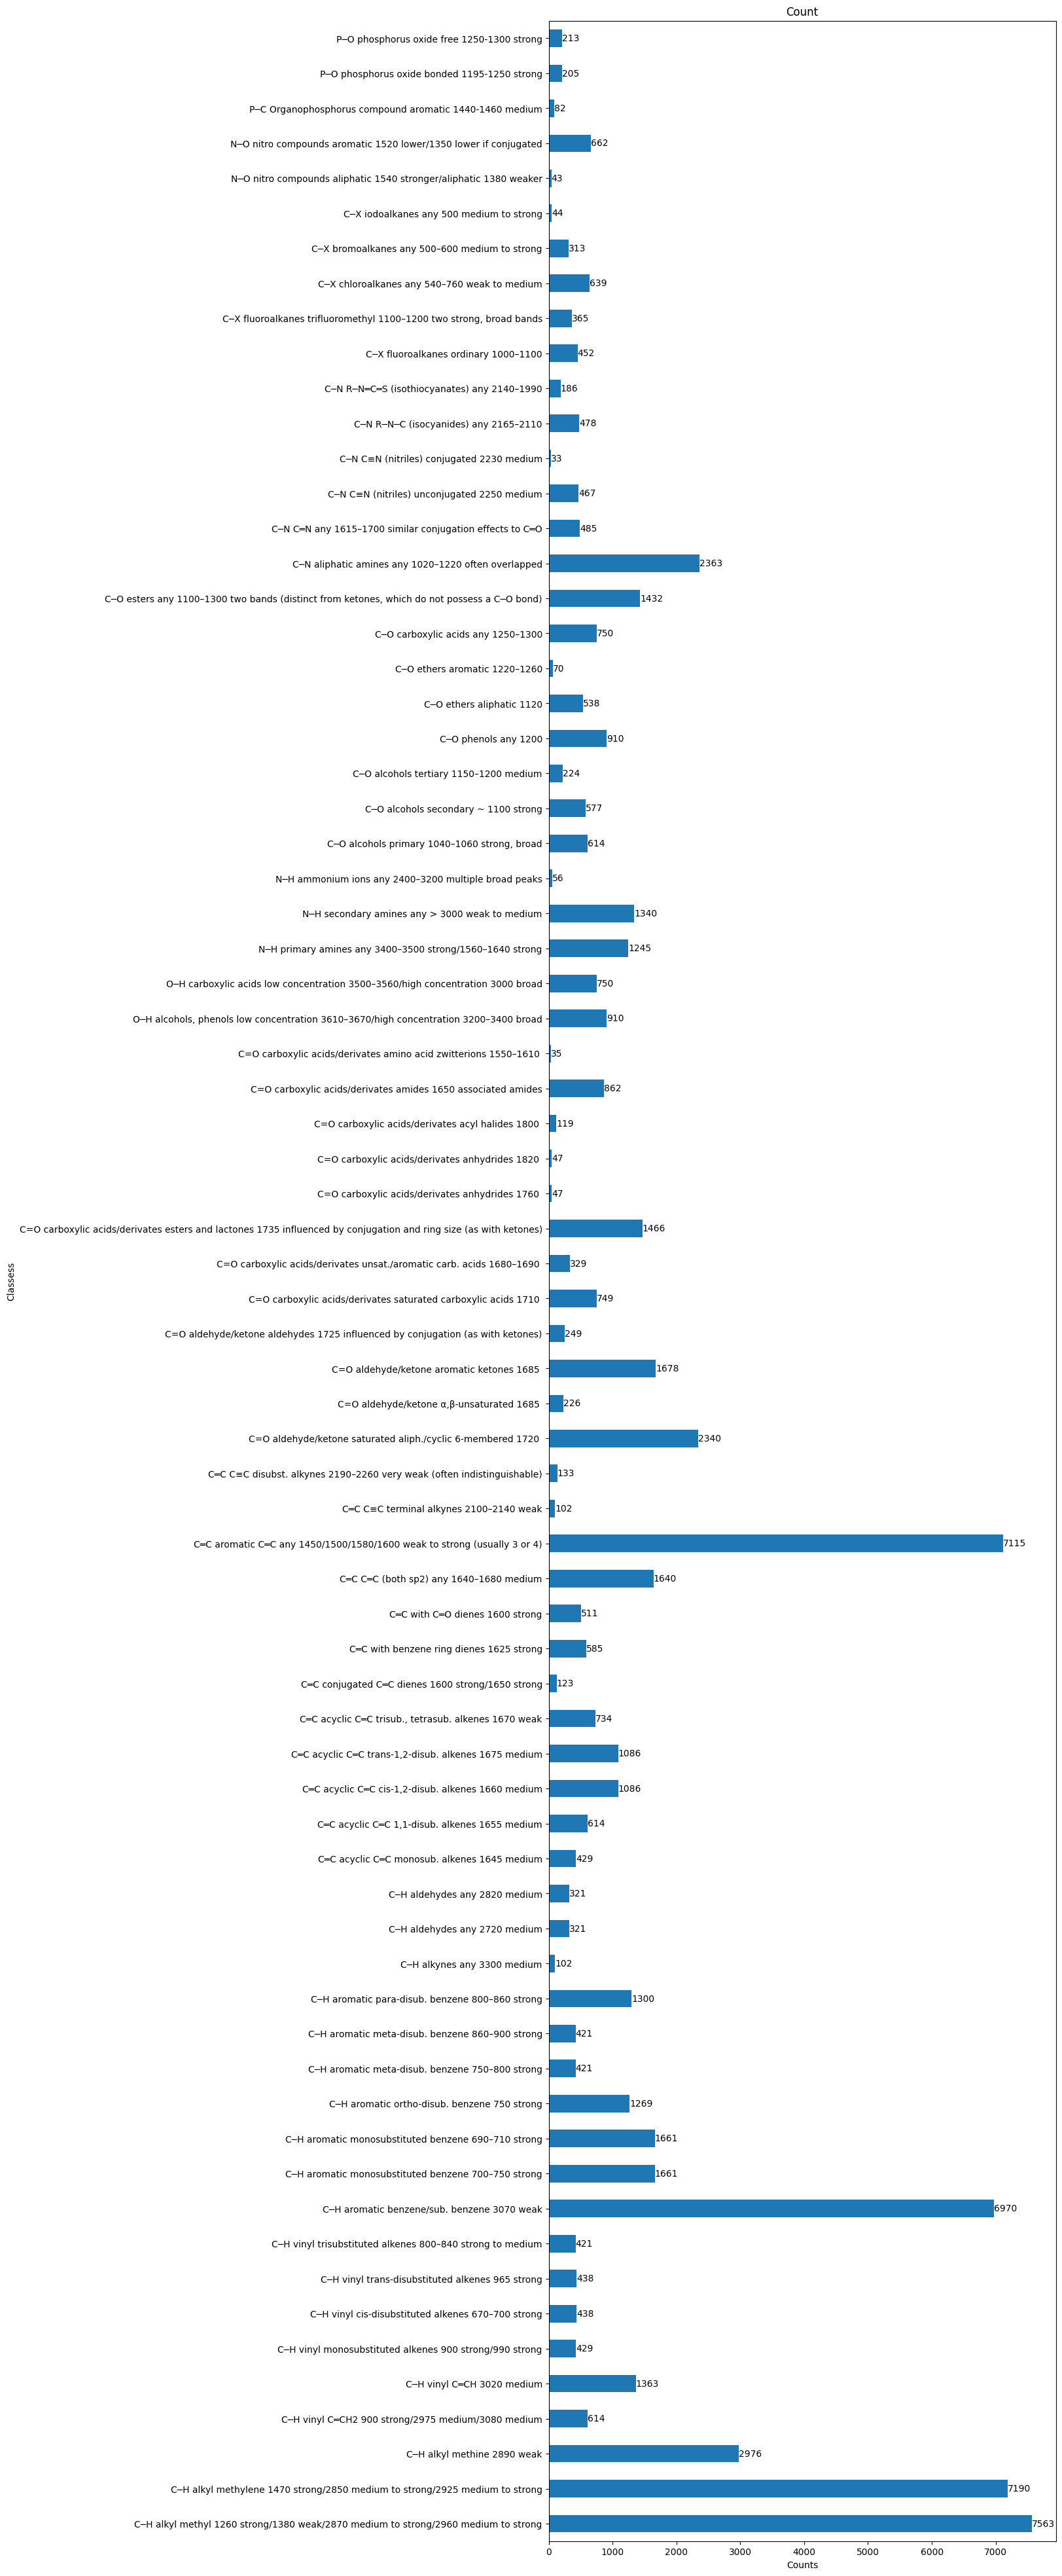

In [63]:
df = pd.DataFrame(sum72[7:])
# plot
ax = df.plot(kind='barh', figsize=(10, 50), title='Count',
             xlabel='Counts', ylabel='Classess', legend=False)

# annotate
ax.bar_label(ax.containers[0], label_type='edge')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

#Форматирование спектров в единый формат. Фильтрация неформатных спектров.

##Формирование статистики по диапазонам спектров.

Приведение спектров к одному формату по осям. Переназначение клеток таблицы, если формат оси был другой. Расчёт шага спектра в случае отсутствия оного.

In [64]:
from jcamp import jcamp_readfile
nist_ir_spectra_list_with_group = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
# Create an empty list to store spectra data
ref_spectra = []
# choose current directory
curr_directory = os.getcwd()
os.chdir(curr_directory)  # set to current directory
files = glob.glob('/content/IR_expert_system/downloaded_jcamp/ir/*')  # look for files without extension. Returns a list.
# Try to read the file. If can't be read, skip it.
dataset_dic = {}
for i, file in enumerate(files):

    #print(file)
    try:
        # read jcamp file using the jcamp class and store data into the
        # ref_spectra list
        sample = jcamp_readfile(file)
        #Forming data into the types
        sample['x'] = sample['x'].astype(np.float32)
        sample['y'] = sample['y'].astype(np.float32)
        sample['firstx'] = np.float32(sample['x'][0])
        #print(type(sample['firstx']))
        sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
        sample['npoints'] = int(sample['npoints'])
        # uniformize data, #1:
        # check yunits: If yunits is in transmission, change it to absorbance.
        # Later create a function to uniformize units
        if sample['yunits'] == "ABSORBANCE":
            pass

        elif sample['yunits'] == "TRANSMISSION" or sample['yunits'] == "TRANSMITTANCE":

            sample['y'] = 1 - sample['y']
            sample['yunits'] = "ABSORBANCE"

            #normalize

        # check xunits: if in microns, change to 1/cm

        if sample['xunits'] == "MICROMETERS":
            sample['x'] = 10000 / sample['x']
            sample['xunits'] = '1/CM'
            sample['firstx'] = np.float32(sample['x'][0])
            sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])
            sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
            #if sample['deltax'] == np.nan: print(float(sample['firstx'])-float(sample['lastx'])), float(sample['npoints'])
            sample['maxx'] =  np.float32(max(sample['x']))
            sample['minx'] =  np.float32(min(sample['x']))
        # check deltax: if Nan, change to (maxx-minx)/npoints
        #if sample['deltax'] == np.nan: sample['deltax'] = ((float(sample['firstx'])-float(sample['lastx']))/float(sample['npoints']))

        # !Still need to uniformize x-axis range and uniformize x-axis intervals.
        #Flitting the x array if it is not in min_to_max order
        if sample['x'][0] > sample['x'][3]:
           #print(sample['x'])
           sample['x'] = np.flip(sample['x'])
           #print(sample['x'])
           sample['y'] = np.flip(sample['y'])
           sample['firstx'] = np.float32(sample['x'][0])
           sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])


        #Saving data to dictionary under cas num
        dataset_dic[sample['cas registry no']] = sample
        #print(sample['cas registry no'])
        # Nan check
        if np.isnan(sample['y']).any(): print("Reading jcamp problem! Nan observed in Y")


    except:
         print("File can't be read, please check:", file)
         continue

#print(dataset_dic)
clear_output()

In [65]:
dataset_df = pd.DataFrame(dataset_dic)
dataset_df = dataset_df.transpose()
dataset_df[['x', 'y', 'minx', 'maxx', 'npoints']]

,x,y,minx,maxx,npoints
78-78-4,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.001633116, 0.010343068, 0.012384463, 0.0111...",450,3966,880
7154-80-5,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[6.57e-05, 0.000117, 0.0001161, 0.0001107, 0.0...",550,3846,825
4726-14-1,"[381.0, 382.0, 383.0, 384.0, 385.0, 386.0, 387...","[0.1778, 0.17659998, 0.17519999, 0.17390001, 0...",381,3790,3410
2243-32-5,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[0.0022622, 0.0021922, 0.0023622, 0.0023722, 0...",549.759,4000.7,1790
71691-56-0,"[648.4495, 648.7318, 649.01434, 649.2968, 649....","[0.366, 0.366, 0.366, 0.366, 0.366, 0.366, 0.3...",648.449524,4828.584961,1993
...,...,...,...,...,...
5049-61-6,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.00259, 0.002112, 0.001806, 0.001826, 0.0017...",550,3846,825
4116-93-2,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.000357, 0.0005292, 0.0006468, 0.0006384, 0....",550,3846,825
19770-99-1,"[402.0, 403.0, 404.0, 405.0, 406.0, 407.0, 408...","[0.2496, 0.25230002, 0.25480002, 0.254, 0.2523...",402,4000,3599
91391-83-2,"[625.2501, 625.51605, 625.7822, 626.05597, 626...","[0.41900003, 0.41399997, 0.412, 0.411, 0.411, ...",625.250122,4950.495117,2053


In [66]:
dataset_df.npoints.mean()

1840.4339491111887

In [67]:
dataset_df.minx.mean()

530.5642325213411

In [68]:
dataset_df.maxx.mean()

4107.103064060134

По всем прочинанным спектрам среднее значение 1800 точек. А диапазон должен быть примерно 500-4100. Что соответствует шагу в 2 (1/см).


##Формирование диапазонов в 500-4100 [1/см] с шагом 2 [1/cm].

### Паддинг недостающих частей спектра.

Вид спектра:

In [69]:
x = dataset_df[['x']].iloc[1].tolist()
y = dataset_df[['y']].iloc[1].tolist()

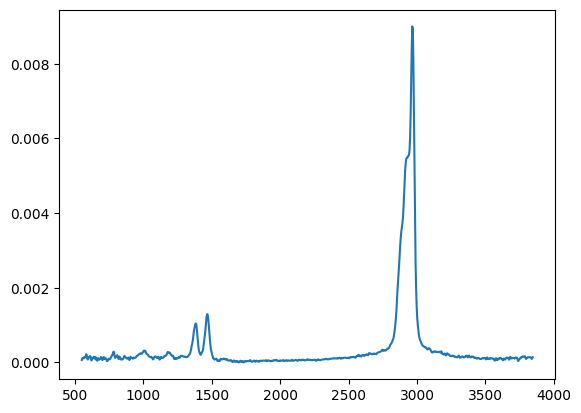

In [70]:
plt.plot(x[0], y[0])

In [71]:
#Добавление к краям с исходным шагом крайнего значения y.
def padding_ir_below(x, y, low_border):
  '''
    x, y - array-like data
    low_border - border until which padding will continue

    return padded x and y as lists
  '''
  x, y = list(x), list(y)
  deltax = x[1]-x[0]
  next_x = x[0]-deltax
  while next_x > low_border:
    x.insert(0, next_x)
    y.insert(0, y[0])
    next_x = x[0]-deltax
  #Последняя итерация чтобы выйти за границу интерполирования
  x.insert(0, next_x)
  y.insert(0, y[0])
  next_x = x[0]-deltax
  return x, y

def padding_ir_above(x, y, high_border):
  '''
    x, y - array-like data
    high_border - border until which padding will continue


    return padded x and y as lists
  '''
  x, y = list(x), list(y)
  deltax = x[1]-x[0]
  next_x = x[-1]+deltax
  while next_x < high_border:
    x.append(next_x)
    y.append(y[-1])
    next_x = x[-1]+deltax
  #Последняя итерация чтобы выйти за границу интерполирования
  x.append(next_x)
  y.append(y[-1])
  next_x = x[-1]+deltax
  return x, y

from scipy import interpolate

def interpolate_in_borders_with_delta(x, y, borders = [500, 4100], deltax = 2):
  '''
  x, y - array like data
  borders - list of [low_border, high border]
  deltax - increment of new data

  returns new x, y data as lists with increment = deltax
  '''
  x, y = list(x), list(y)
  f = interpolate.interp1d(x, y)
  #print(f(x[0]))
  x_new = []
  for i in range(borders[0], borders[1], deltax):
    x_new.append(i)
  x_new = np.array(x_new)
  y_new = f(x_new)

  return x_new, y_new

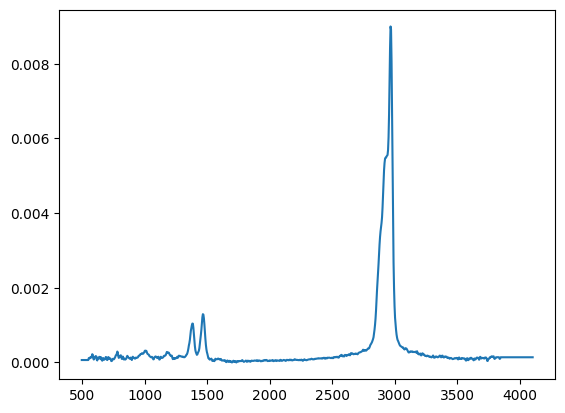

In [72]:
x, y = padding_ir_below(x[0], y[0], 500.0)
x, y = padding_ir_above(x, y, 4100.0)
plt.plot(x, y)

###Функция для интерполирования:

In [73]:
from scipy import interpolate

def interpolate_in_borders_with_delta(x, y, borders = [500, 4100], deltax = 2):
  '''
  x, y - array like data
  borders - list of [low_border, high border]
  deltax - increment of new data

  returns new x, y data as lists with increment = deltax
  '''
  x, y = list(x), list(y)
  f = interpolate.interp1d(x, y)
  #print(f(x[0]))
  x_new = []
  for i in range(borders[0], borders[1], deltax):
    x_new.append(i)
  x_new = np.array(x_new)
  y_new = f(x_new)

  return x_new, y_new



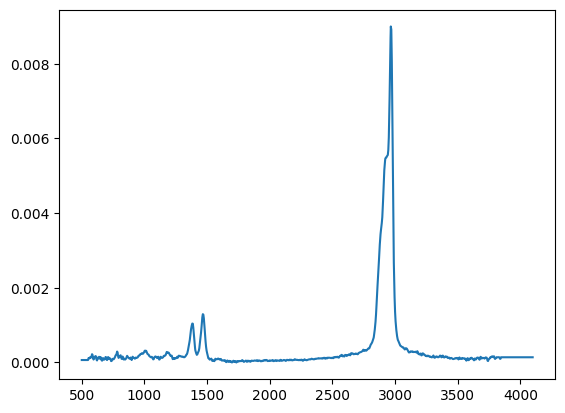

In [74]:
x1, y1 = interpolate_in_borders_with_delta(x, y)
plt.plot(x1, y1)

In [75]:
print(x1)
print(len(x1))
print(y1)
print(len(y1))

[ 500  502  504 ... 4094 4096 4098]
1800
[6.56999982e-05 6.56999982e-05 6.56999982e-05 ... 1.39500000e-04
 1.39500000e-04 1.39500000e-04]
1800


###Интерполирование всех спектров до одного размера и шага.

In [76]:
len(dataset_df[['x']])

14345

In [77]:
x = dataset_df[['x']].iloc[1].to_numpy()
y = dataset_df[['y']].iloc[1].to_numpy()

In [78]:
x_list, y_list = [], []
errors = 0
for i in tqdm(range(len(dataset_df[['x']]))):
  try:
      x, y = dataset_df[['x']].iloc[i].tolist(), dataset_df[['y']].iloc[i].tolist()
      x1, y1 = padding_ir_below(x[0], y[0], 500.0)

      x2, y2 = padding_ir_above(x1, y1, 4100.0)

      x3, y3 = interpolate_in_borders_with_delta(x2, y2)
      x_list.append(x3)
      y_list.append(y3)
  except ValueError:
      #print(f'0: {len(x)}, {len(y)}, 1: {len(x1)}, {len(y1)}, 2: {len(x2)}, {len(y2)}')
      errors +=errors
      x_list.append(np.nan)
      y_list.append(np.nan)
print(f'Found {errors} errors')

100%|██████████| 14345/14345 [01:30<00:00, 157.95it/s]

Found 0 errors


In [79]:
print(len(x_list))
print(len(y_list))

14345
14345


In [80]:
# for i in range(len(x_list)):
#   x_list[i]= x_list[i].astype(np.float32)
#   y_list[i]=y_list[i].astype(np.float32)

In [81]:
x_arr = np.array(x_list)
y_arr = np.array(y_list)

<ipython-input-81-5b43c0e179b1>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_arr = np.array(x_list)
<ipython-input-81-5b43c0e179b1>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_arr = np.array(y_list)


In [82]:
x_serie = pd.Series(x_arr)
#rint(len(x_serie[0]))
y_serie = pd.Series(y_arr)
#print(type(x_serie))

In [83]:
df_x = pd.DataFrame(x_serie, columns = ['x1'])
df_y = pd.DataFrame(y_serie, columns = ['y1'])
x, y = np.array(df_x.loc[10])[0], np.array(df_y.loc[10])[0]
#print(y)

## Нахождение пиков


In [84]:
from peakutils.peak import indexes as index_utils
def find_peaks_indx(y):
  index = index_utils(np.array(y), thres=0.05*max(y), min_dist=10, thres_abs = True)
  return index

x_list, y_list = [], []
y_peak_indx_list = []
errors = 0
for i in tqdm(range(len(dataset_df[['x']]))):
  try:
      x, y = dataset_df[['x']].iloc[i].tolist(), dataset_df[['y']].iloc[i].tolist()
      x1, y1 = padding_ir_below(x[0], y[0], 500.0)

      x2, y2 = padding_ir_above(x1, y1, 4100.0)

      x3, y3 = interpolate_in_borders_with_delta(x2, y2)
      y_peak_indx = find_peaks_indx(y3)
      y_peak_indx_list.append(y_peak_indx)
      x_list.append(x3)
      y_list.append(y3)
  except ValueError:
      #print(f'0: {len(x)}, {len(y)}, 1: {len(x1)}, {len(y1)}, 2: {len(x2)}, {len(y2)}')
      errors +=1
      x_list.append(np.nan)
      y_list.append(np.nan)
      y_peak_indx_list.append(np.nan)
print(f'Found {errors} errors')


100%|██████████| 14345/14345 [02:10<00:00, 109.58it/s]

Found 38 errors


In [85]:
#Создаём последовательность значений частот только для пиков
x_peak_list = []
for peak_indx_list in y_peak_indx_list:
  #print(peak_indx_list)
  x_peak = []
  try:
      for j in peak_indx_list:

          x_peak.append(x_list[0][j])

      x_peak_list.append(x_peak)
  except:
      x_peak_list.append(np.nan)
print(len(x_peak_list))
print(len(x_peak_list[0]))
print(x_peak_list)

14345
4
[[1382, 1470, 2890, 2966], [1382, 1466, 2966], [504, 536, 572, 614, 658, 712, 748, 778, 802, 912, 976, 1040, 1098, 1130, 1180, 1218, 1264, 1320, 1354, 1400, 1434, 1462, 1486, 1534, 1606, 1832, 1906, 2060, 2096, 2174, 2254, 2282, 2376, 2428, 2566, 2624, 2876, 2936, 2968, 3020, 3052, 3120, 3436, 3674, 3764], [604, 630, 656, 750, 776, 1022, 1048, 1072, 1134, 1236, 1280, 1320, 1392, 1428, 1720, 1762, 2890, 2942, 3002, 3556], [658, 684, 714, 748, 782, 808, 846, 870, 904, 930, 966, 1032, 1092, 1146, 1172, 1220, 1252, 1300, 1364, 1458, 1522, 1568, 1606, 1630, 1654, 1730, 1840, 1878, 1922, 1956, 1988, 2014, 2056, 2094, 2138, 2178, 2204, 2238, 2296, 2332, 2396, 2420, 2476, 2568, 2636, 2698, 2920, 3066, 3136, 3394, 3568, 3730, 3782, 3860, 3936, 4000, 4070], [628, 666, 708, 790, 834, 900, 936, 988, 1014, 1076, 1100, 1148, 1198, 1250, 1272, 1326, 1370, 1414, 1448, 1474, 1624, 1702, 1742, 1794, 1874, 1906, 1948, 1984, 2028, 2086, 2194, 2238, 2278, 2366, 2470, 2702, 2962, 3444, 3752], [678, 

In [86]:
#Создаём дополнительный слой для входа в сеть, где +/- вокруг пика будет от 0 до 1, а вне - 0.
#def print_peak_neighborhood(peak_indx, num_neighbors = 10):
num_neighbors = 10
y_masked_list = []
for i in range(len(y_list)):
  try:
    y_masked = np.zeros(len(y_list[i]))

    for j in y_peak_indx_list[i]:
      for k in range(num_neighbors):
          y_masked[j-k] = 1-(1/num_neighbors)*k
          y_masked[j+k] = 1-(1/num_neighbors)*k

      #print(y_masked[28:48])



    y_masked_list.append(y_masked)
  except:
    y_masked_list.append(np.nan)

In [87]:
x_serie = pd.Series(x_list)
y_serie = pd.Series(y_list)
y_peak_serie = pd.Series(y_masked_list)
x_peak_serie = pd.Series(x_peak_list)

In [88]:
df = pd.DataFrame(x_serie, columns = ['x1'])
df['y1'] = y_serie
df['y_peak'] = y_masked_list
df['x_peak'] = x_peak_serie

In [89]:
dataset_df = dataset_df.reset_index()
dataset_df1 = dataset_df.join(df, lsuffix='x')
dataset_df1[['x', 'x1', 'y', 'y1', 'y_peak', 'x_peak']]

,x,x1,y,y1,y_peak,x_peak
0,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.001633116, 0.010343068, 0.012384463, 0.0111...","[0.008709951769560575, 0.009934788569808006, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1382, 1470, 2890, 2966]"
1,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[6.57e-05, 0.000117, 0.0001161, 0.0001107, 0.0...","[6.569999823113903e-05, 6.569999823113903e-05,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1382, 1466, 2966]"
2,"[381.0, 382.0, 383.0, 384.0, 385.0, 386.0, 387...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.1778, 0.17659998, 0.17519999, 0.17390001, 0...","[0.28390002250671387, 0.29269999265670776, 0.2...","[0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.399...","[504, 536, 572, 614, 658, 712, 748, 778, 802, ..."
3,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0022622, 0.0021922, 0.0023622, 0.0023722, 0...","[0.0022621999960392714, 0.0022621999960392714,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[604, 630, 656, 750, 776, 1022, 1048, 1072, 11..."
4,"[648.4495, 648.7318, 649.01434, 649.2968, 649....","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.366, 0.366, 0.366, 0.366, 0.366, 0.366, 0.3...","[0.3659999966621399, 0.3659999966621399, 0.365...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[658, 684, 714, 748, 782, 808, 846, 870, 904, ..."
...,...,...,...,...,...,...
14340,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.00259, 0.002112, 0.001806, 0.001826, 0.0017...","[0.002589999930933118, 0.002589999930933118, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[562, 602, 662, 710, 750, 830, 1010, 1050, 118..."
14341,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.000357, 0.0005292, 0.0006468, 0.0006384, 0....","[0.00035700001171790063, 0.0003570000117179006...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1330, 1378, 1446, 2874, 2934, 3006, 3034]"
14342,"[402.0, 403.0, 404.0, 405.0, 406.0, 407.0, 408...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.2496, 0.25230002, 0.25480002, 0.254, 0.2523...","[0.09950000047683716, 0.07150000333786011, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[536, 574, 598, 694, 728, 758, 806, 842, 870, ..."
14343,"[625.2501, 625.51605, 625.7822, 626.05597, 626...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.41900003, 0.41399997, 0.412, 0.411, 0.411, ...","[0.4190000295639038, 0.4190000295639038, 0.419...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[628, 670, 698, 744, 802, 832, 870, 906, 946, ..."


# Сохранение данных на диск

In [90]:
from google.colab import files
def save_dataset(dataset_df, num_parts = 10):
  '''
  Функция для сохранения тяжёлого датасета с разбивкой на части меньще 100 Мб

  Parameters:
    dataset_df - pd.Dataframe - таблицу, которую надо сохранять
    num_parts - 10 - количество частей, на которые нужно разбить таблицу
  '''
  start = 0
  step = len(dataset_df)//num_parts
  for i in range(num_parts):
    end = step*(i+1)
    if i == num_parts-1:
      if end < len(dataset_df): end = len(dataset_df)
    dataset_df[start:end].to_pickle('/content/IR_expert_system/data/datasets/dataset4/nist_ir_spectra_dataset4_'+str(i)+'.pkl')
    files.download('/content/IR_expert_system/data/datasets/dataset4/nist_ir_spectra_dataset4_'+str(i)+'.pkl')

In [91]:
#save_dataset(dataset_df1)